# Generate displacement data using OPERA CSLC-S1 from ASF DAAC

---    

### Data Used in the Example:   

- **10 meter (Northing) x 5 meter (Easting) North America OPERA Coregistered Single Look Complex from Sentinel-1 products**
    - This dataset contains Level-2 OPERA provisional coregistered single-look-complex (CSLC) data from Sentinel-1 (S1). <span style="color:red"> The data in this example are geocoded CSLC-S1 data covering the volcanoes in the Big Island, Hawaii</span>. 
    
    - The OPERA project is generating geocoded burst-wise CSLC-S1 products over North America which includes USA and US Territories within 200 km from the US border, Canada, and all mainland countries from the southern US border down to and including Panama. Each pixel within a burst SLC is represented by a complex number and contains both the amplitude and phase information. The CSLC-S1 products are distributed over projected map coordinates using the Universal Transverse Mercator (UTM) projection with spacing in the X- and Y-directions of 5 m and 10 m, respectively. Each OPERA CSLC-S1 product is distributed as a HDF5 file following the CF-1.8 convention with separate groups containing the data raster layers, the low-resolution correction layers, and relevant product metadata.

    - For more information about the OPERA project and other products please visit our website at https://www.jpl.nasa.gov/go/opera .

Please refer to the [OPERA Product Specification Document](https://d2pn8kiwq2w21t.cloudfront.net/documents/ProductSpec_CSLC_URS314199.pdf) for details about the CSLC-S1 product.

*Prepared by M. Grace Bato*

---

## 0. Setup your conda environment

Assuming you have [miniconda](https://docs.conda.io/projects/miniconda/en/latest/miniconda-install.html) or conda installed. Open your terminal and run the following:
```
> conda create -n opera_cslc --yes
> conda activate opera_cslc
> conda install -c conda-forge mamba --yes
> mamba env update -p ${CONDA_PREFIX} --file "opera_cslc_env.yml"
> pip install -U git+https://github.com/scottstanie/dolphin.git@main
```

---    

## 1. Load Python modules

In [1]:
## Load necessary modules
%load_ext watermark

import asf_search as asf
import geopandas as gpd

import numpy as np
import getpass
import folium
import datetime as dt
from shapely.geometry import box
import rioxarray
import numpy as np
from dolphin.workflows import _cli_config as dconfig
from dolphin.workflows import _cli_run as drun

%watermark --iversions

import os

asf_search: 6.7.2
rioxarray : 0.15.0
dolphin   : 0.7.0.post1.dev23+gbd31392
folium    : 0.15.1
geopandas : 0.14.1
numpy     : 1.26.2



In [2]:
## Load plotting module
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
## Load pandas and setup config
import pandas as pd
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
## Avoid lots of these warnings printing to notebook from asf_search
import warnings
warnings.filterwarnings('ignore')

## 2. Query and download OPERA CSLCs using `asf_search`

In [5]:
## Enter user-defined parameters
aoi = box(-155.88, 19.0, -155.014, 20.1962)     # (W, N, E, S)
wavelength = 0.056
orbitPass = asf.ASCENDING
pathNumber = 124
referenceDate = dt.datetime.fromisoformat('2023-12-26 00:00:00')         #'YYYY-MM-DDTHH:MM:SSZ'
secondaryDate = dt.datetime.fromisoformat('2024-01-07 23:59:59')         #'YYYY-MM-DDTHH:MM:SSZ'
savedir = './BigIsland'

In [6]:
## Search for OPERA CSLC data in ASF DAAC
search_params = dict(
    intersectsWith= aoi.wkt,
    dataset='OPERA-S1',
    processingLevel='CSLC',
    flightDirection = orbitPass,
    start=referenceDate,
    end=secondaryDate
)

## Return results
results = asf.search(**search_params)
len(results)

49

In [7]:
## Display the queried data
gf = gpd.GeoDataFrame.from_features(results.geojson(), crs='EPSG:4326')
gf.head()

geometry beamModeType  \
0  POLYGON ((-156.15805 20.12379, -155.30886 20.2...           IW   
1  POLYGON ((-155.30803 20.16291, -154.55745 20.2...           IW   
2  POLYGON ((-156.12386 19.95632, -155.27562 20.1...           IW   
3  POLYGON ((-155.27494 19.99643, -154.52520 20.1...           IW   
4  POLYGON ((-156.08986 19.78971, -155.24255 19.9...           IW   

                                              browse bytes centerLat  \
0  [https://datapool.asf.alaska.edu/BROWSE/OPERA-...  None      None   
1  [https://datapool.asf.alaska.edu/BROWSE/OPERA-...  None      None   
2  [https://datapool.asf.alaska.edu/BROWSE/OPERA-...  None      None   
3  [https://datapool.asf.alaska.edu/BROWSE/OPERA-...  None      None   
4  [https://datapool.asf.alaska.edu/BROWSE/OPERA-...  None      None   

  centerLon faradayRotation  \
0      None            None   
1      None            None   
2      None            None   
3      None            None   
4      None            None   

                                              fileID flightDirection  \
0  OPERA_L2_CSLC-S1_T124-264311-IW2_20240107T0431...       ASCENDING   
1  OPERA_L2_CSLC-S1_T124-264310-IW3_20240107T0431...       ASCENDING   
2  OPERA_L2_CSLC-S1_T124-264310-IW2_20240107T0431...       ASCENDING   
3  OPERA_L2_CSLC-S1_T124-264309-IW3_20240107T0431...       ASCENDING   
4  OPERA_L2_CSLC-S1_T124-264309-IW2_20240107T0431...       ASCENDING   

                         groupID granuleType insarStackId md5sum  \
0  S1A_IWDV_0062_0068_051996_124        None         None   None   
1  S1A_IWDV_0062_0068_051996_124        None         None   None   
2  S1A_IWDV_0062_0068_051996_124        None         None   None   
3  S1A_IWDV_0062_0068_051996_124        None         None   None   
4  S1A_IWDV_0062_0068_051996_124        None         None   None   

  offNadirAngle  orbit  pathNumber     platform pointingAngle polarization  \
0          None  51996         124  Sentinel-1A          None         [VV]   
1          None  51996         124  Sentinel-1A          None         [VV]   
2          None  51996         124  Sentinel-1A          None         [VV]   
3          None  51996         124  Sentinel-1A          None         [VV]   
4          None  51996         124  Sentinel-1A          None         [VV]   

         processingDate processingLevel  \
0  2024-01-09T04:16:21Z            CSLC   
1  2024-01-09T04:28:16Z            CSLC   
2  2024-01-09T04:14:49Z            CSLC   
3  2024-01-09T04:26:54Z            CSLC   
4  2024-01-09T04:13:17Z            CSLC   

                                           sceneName sensor  \
0  OPERA_L2_CSLC-S1_T124-264311-IW2_20240107T0431...  C-SAR   
1  OPERA_L2_CSLC-S1_T124-264310-IW3_20240107T0431...  C-SAR   
2  OPERA_L2_CSLC-S1_T124-264310-IW2_20240107T0431...  C-SAR   
3  OPERA_L2_CSLC-S1_T124-264309-IW3_20240107T0431...  C-SAR   
4  OPERA_L2_CSLC-S1_T124-264309-IW2_20240107T0431...  C-SAR   

              startTime              stopTime  \
0  2024-01-07T04:31:32Z  2024-01-07T04:31:36Z   
1  2024-01-07T04:31:31Z  2024-01-07T04:31:34Z   
2  2024-01-07T04:31:30Z  2024-01-07T04:31:33Z   
3  2024-01-07T04:31:28Z  2024-01-07T04:31:31Z   
4  2024-01-07T04:31:27Z  2024-01-07T04:31:30Z   

                                                 url pgeVersion  \
0  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...      2.1.0   
1  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...      2.1.0   
2  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...      2.1.0   
3  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...      2.1.0   
4  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...      2.1.0   

                                            fileName frameNumber beamMode  \
0  OPERA_L2_CSLC-S1_T124-264311-IW2_20240107T0431...        None       IW   
1  OPERA_L2_CSLC-S1_T124-264310-IW3_20240107T0431...        None       IW   
2  OPERA_L2_CSLC-S1_T124-264310-IW2_20240107T0431...        None       IW   
3  OPERA_L2_CSLC-S1_T124-264309-IW3_20240107T0431...  

In [8]:
## Filter data based on specified track number
gf = gf[gf.pathNumber==pathNumber]
cslc = gf[['operaBurstID','startTime', 'stopTime', 'url', 'geometry']]
cslc['startTime'] = pd.to_datetime(cslc.startTime).dt.date
cslc['stopTime'] = pd.to_datetime(cslc.stopTime).dt.date
cslc = cslc.drop_duplicates(subset=['operaBurstID', 'startTime'], ignore_index=True)
cslc

operaBurstID   startTime    stopTime  \
0   T124_264311_IW2  2024-01-07  2024-01-07   
1   T124_264310_IW3  2024-01-07  2024-01-07   
2   T124_264310_IW2  2024-01-07  2024-01-07   
3   T124_264309_IW3  2024-01-07  2024-01-07   
4   T124_264309_IW2  2024-01-07  2024-01-07   
5   T124_264308_IW3  2024-01-07  2024-01-07   
6   T124_264308_IW2  2024-01-07  2024-01-07   
7   T124_264307_IW3  2024-01-07  2024-01-07   
8   T124_264307_IW2  2024-01-07  2024-01-07   
9   T124_264306_IW3  2024-01-07  2024-01-07   
10  T124_264306_IW2  2024-01-07  2024-01-07   
11  T124_264305_IW3  2024-01-07  2024-01-07   
12  T124_264305_IW2  2024-01-07  2024-01-07   
13  T124_264304_IW3  2024-01-07  2024-01-07   
14  T124_264304_IW2  2024-01-07  2024-01-07   
15  T124_264303_IW3  2024-01-07  2024-01-07   
16  T124_264303_IW2  2024-01-07  2024-01-07   
17  T124_264302_IW3  2024-01-07  2024-01-07   
18  T124_264311_IW2  2023-12-26  2023-12-26   
19  T124_264310_IW3  2023-12-26  2023-12-26   
20  T124_264310_IW2  2023-12-26  2023-12-26   
21  T124_264309_IW3  2023-12-26  2023-12-26   
22  T124_264309_IW2  2023-12-26  2023-12-26   
23  T124_264308_IW3  2023-12-26  2023-12-26   
24  T124_264308_IW2  2023-12-26  2023-12-26   
25  T124_264307_IW3  2023-12-26  2023-12-26   
26  T124_264307_IW2  2023-12-26  2023-12-26   
27  T124_264306_IW3  2023-12-26  2023-12-26   
28  T124_264306_IW2  2023-12-26  2023-12-26   
29  T124_264305_IW3  2023-12-26  2023-12-26   
30  T124_264305_IW2  2023-12-26  2023-12-26   
31  T124_264304_IW3  2023-12-26  2023-12-26   
32  T124_264304_IW2  2023-12-26  2023-12-26   
33  T124_264303_IW3  2023-12-26  2023-12-26   
34  T124_264303_IW2  2023-12-26  2023-12-26   
35  T124_264302_IW3  2023-12-26  2023-12-26   

                                                  url  \
0   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
1   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
2   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
3   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
4   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
5   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
6   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
7   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
8   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
9   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
10  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
11  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
12  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
13  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
14  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
15  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
16  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
17  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
18  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
19  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
20  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
21  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
22  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
23  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
24  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
25  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
26  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
27  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
28  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
29  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
30  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
31  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
32  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
33  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
34  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
35  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   

                                             geometry  
0   POLYGON ((-156.15805 20.12379, -155.30886 20.2...  
1   POLYGON ((-155.30803 20.16291, -154.55745

In [9]:
## Choose the reference and secondary dates
ref = cslc.startTime[0]
sec = cslc.startTime[cslc.tail(1).index[0]]

## Drop other dates
cslc = cslc.loc[cslc.startTime.isin([ref,sec])]
cslc

operaBurstID   startTime    stopTime  \
0   T124_264311_IW2  2024-01-07  2024-01-07   
1   T124_264310_IW3  2024-01-07  2024-01-07   
2   T124_264310_IW2  2024-01-07  2024-01-07   
3   T124_264309_IW3  2024-01-07  2024-01-07   
4   T124_264309_IW2  2024-01-07  2024-01-07   
5   T124_264308_IW3  2024-01-07  2024-01-07   
6   T124_264308_IW2  2024-01-07  2024-01-07   
7   T124_264307_IW3  2024-01-07  2024-01-07   
8   T124_264307_IW2  2024-01-07  2024-01-07   
9   T124_264306_IW3  2024-01-07  2024-01-07   
10  T124_264306_IW2  2024-01-07  2024-01-07   
11  T124_264305_IW3  2024-01-07  2024-01-07   
12  T124_264305_IW2  2024-01-07  2024-01-07   
13  T124_264304_IW3  2024-01-07  2024-01-07   
14  T124_264304_IW2  2024-01-07  2024-01-07   
15  T124_264303_IW3  2024-01-07  2024-01-07   
16  T124_264303_IW2  2024-01-07  2024-01-07   
17  T124_264302_IW3  2024-01-07  2024-01-07   
18  T124_264311_IW2  2023-12-26  2023-12-26   
19  T124_264310_IW3  2023-12-26  2023-12-26   
20  T124_264310_IW2  2023-12-26  2023-12-26   
21  T124_264309_IW3  2023-12-26  2023-12-26   
22  T124_264309_IW2  2023-12-26  2023-12-26   
23  T124_264308_IW3  2023-12-26  2023-12-26   
24  T124_264308_IW2  2023-12-26  2023-12-26   
25  T124_264307_IW3  2023-12-26  2023-12-26   
26  T124_264307_IW2  2023-12-26  2023-12-26   
27  T124_264306_IW3  2023-12-26  2023-12-26   
28  T124_264306_IW2  2023-12-26  2023-12-26   
29  T124_264305_IW3  2023-12-26  2023-12-26   
30  T124_264305_IW2  2023-12-26  2023-12-26   
31  T124_264304_IW3  2023-12-26  2023-12-26   
32  T124_264304_IW2  2023-12-26  2023-12-26   
33  T124_264303_IW3  2023-12-26  2023-12-26   
34  T124_264303_IW2  2023-12-26  2023-12-26   
35  T124_264302_IW3  2023-12-26  2023-12-26   

                                                  url  \
0   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
1   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
2   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
3   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
4   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
5   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
6   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
7   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
8   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
9   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
10  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
11  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
12  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
13  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
14  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
15  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
16  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
17  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
18  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
19  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
20  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
21  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
22  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
23  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
24  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
25  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
26  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
27  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
28  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
29  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
30  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
31  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
32  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
33  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
34  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
35  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   

                                             geometry  
0   POLYGON ((-156.15805 20.12379, -155.30886 20.2...  
1   POLYGON ((-155.30803 20.16291, -154.55745

In [10]:
## Ensure that you have 2 cslcs per operaBurstID
cslc.operaBurstID.value_counts()

operaBurstID
T124_264311_IW2    2
T124_264310_IW3    2
T124_264303_IW2    2
T124_264303_IW3    2
T124_264304_IW2    2
T124_264304_IW3    2
T124_264305_IW2    2
T124_264305_IW3    2
T124_264306_IW2    2
T124_264306_IW3    2
T124_264307_IW2    2
T124_264307_IW3    2
T124_264308_IW2    2
T124_264308_IW3    2
T124_264309_IW2    2
T124_264309_IW3    2
T124_264310_IW2    2
T124_264302_IW3    2
Name: count, dtype: int64

In [11]:
## Keep only bursts that have at least 2 counts of data
counts = cslc.operaBurstID.value_counts()
cslc = cslc.loc[~cslc['operaBurstID'].isin(counts[counts < 2].index)].reset_index(drop=True)
cslc

operaBurstID   startTime    stopTime  \
0   T124_264311_IW2  2024-01-07  2024-01-07   
1   T124_264310_IW3  2024-01-07  2024-01-07   
2   T124_264310_IW2  2024-01-07  2024-01-07   
3   T124_264309_IW3  2024-01-07  2024-01-07   
4   T124_264309_IW2  2024-01-07  2024-01-07   
5   T124_264308_IW3  2024-01-07  2024-01-07   
6   T124_264308_IW2  2024-01-07  2024-01-07   
7   T124_264307_IW3  2024-01-07  2024-01-07   
8   T124_264307_IW2  2024-01-07  2024-01-07   
9   T124_264306_IW3  2024-01-07  2024-01-07   
10  T124_264306_IW2  2024-01-07  2024-01-07   
11  T124_264305_IW3  2024-01-07  2024-01-07   
12  T124_264305_IW2  2024-01-07  2024-01-07   
13  T124_264304_IW3  2024-01-07  2024-01-07   
14  T124_264304_IW2  2024-01-07  2024-01-07   
15  T124_264303_IW3  2024-01-07  2024-01-07   
16  T124_264303_IW2  2024-01-07  2024-01-07   
17  T124_264302_IW3  2024-01-07  2024-01-07   
18  T124_264311_IW2  2023-12-26  2023-12-26   
19  T124_264310_IW3  2023-12-26  2023-12-26   
20  T124_264310_IW2  2023-12-26  2023-12-26   
21  T124_264309_IW3  2023-12-26  2023-12-26   
22  T124_264309_IW2  2023-12-26  2023-12-26   
23  T124_264308_IW3  2023-12-26  2023-12-26   
24  T124_264308_IW2  2023-12-26  2023-12-26   
25  T124_264307_IW3  2023-12-26  2023-12-26   
26  T124_264307_IW2  2023-12-26  2023-12-26   
27  T124_264306_IW3  2023-12-26  2023-12-26   
28  T124_264306_IW2  2023-12-26  2023-12-26   
29  T124_264305_IW3  2023-12-26  2023-12-26   
30  T124_264305_IW2  2023-12-26  2023-12-26   
31  T124_264304_IW3  2023-12-26  2023-12-26   
32  T124_264304_IW2  2023-12-26  2023-12-26   
33  T124_264303_IW3  2023-12-26  2023-12-26   
34  T124_264303_IW2  2023-12-26  2023-12-26   
35  T124_264302_IW3  2023-12-26  2023-12-26   

                                                  url  \
0   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
1   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
2   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
3   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
4   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
5   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
6   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
7   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
8   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
9   https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
10  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
11  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
12  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
13  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
14  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
15  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
16  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
17  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
18  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
19  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
20  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
21  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
22  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
23  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
24  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
25  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
26  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
27  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
28  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
29  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
30  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
31  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
32  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
33  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
34  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   
35  https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...   

                                             geometry  
0   POLYGON ((-156.15805 20.12379, -155.30886 20.2...  
1   POLYGON ((-155.30803 20.16291, -154.55745

In [12]:
## Basemap function for Folium
def getbasemaps():
    # Add custom base maps to folium
    basemaps = {
        'Google Satellite Hybrid': folium.TileLayer(
            tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
            attr = 'Google',
            name = 'Google Satellite',
            overlay = True,
            control = True,
            # opacity = 0.8,
            show = False
        ),
        'Esri Satellite': folium.TileLayer(
            tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
            attr = 'Esri',
            name = 'Esri Satellite',
            overlay = True,
            control = True,
            #opacity = 0.8,
            show = False
        )
    }
    return basemaps

In [13]:
# Interactive map to visualize the boundaries of the selected OPERA CSLCs
m = folium.Map(location=[aoi.centroid.y, aoi.centroid.x], zoom_start=4, tiles="CartoDB positron")

# Add custom basemaps
basemaps = getbasemaps()
for basemap in basemaps:
    basemaps[basemap].add_to(m)

# layer Control
m.add_child(folium.LayerControl())

## RLE sites
for _, r in cslc.iterrows():
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"color": "red"}, control=False)
    folium.Popup(r["operaBurstID"]).add_to(geo_j)
    geo_j.add_to(m)

m

In [14]:
## Download the relevant OPERA CSLCs to a temporary "cslc" folder 
os.makedirs(f'{savedir}/cslc', exist_ok='True')
asf.download_urls(urls=cslc.url, path=f'{savedir}/cslc', processes=10)

## 3. Create burst-wise IFGs, stitch, and unwrap using Dolphin

In [15]:
# Go to the working/save directory
os.chdir(f'{savedir}')

In [16]:
# # Create waterMask if waterMask is not available
# # You must install isce2, mintpy, and gdal
# # Run wbd.py from isce2, generate mask using from MintPy, crop mask to the same area extent of the IFG

# !wbd.py 18 21 -157 -154
# !generate_mask.py swbdLat_N18_N21_Lon_W157_W154.wbd --max 0.5 -o waterMask.h5
# !save_gdal.py waterMask.h5 -o waterMask.tif
# !gdalwarp -t_srs EPSG:32605 -te 161040.0000000000000000 2075280.0000000000000000 368430.0000000000000000 2271570.0000000000000000 waterMask.tif sub_waterMask_utm.tif -ot Byte -overwrite -tr 30 -30

In [17]:
# # For this Big Island case, ensure you have the mask_file.
dconfig.create_config(outfile='dolphin_config.yaml', slc_files='./cslc/*.h5',\
                      subdataset='/data/VV', strides=[6, 3], n_workers=4, threads_per_worker= 16, mask_file='./WBD/sub_waterMask_utm.tif')

# # No unwrapping option: --no-unwrap=True
# dconfig.create_config(outfile='dolphin_config.yaml', slc_files='./cslc/*.h5',\
#                       subdataset='/data/VV', strides=[6, 3], n_workers=2, threads_per_worker=16,  mask_file='./WBD/sub_waterMask_utm.tif', no_unwrap=True)

## Via command line input
# !dolphin config --slc-files ./cslc/*.h5 --subdataset "/data/VV" --strides 6 3 --n-workers 2 --threads-per-worker 16 --mask-file './WBD/sub_waterMask_utm.tif'
# !dolphin config --slc-files ./cslc/*.h5 --subdataset "/data/VV" --strides 6 3 --n-workers 2 --threads-per-worker 16 --mask-file './WBD/sub_waterMask_utm.tif' --no-unwrap

Saving configuration to dolphin_config.yaml


In [18]:
%%time
drun.run('dolphin_config.yaml')

## Via command line input
# !dolphin run dolphin_config.yaml

[2024-01-17 14:15:47] INFO     Found SLC files from 18 bursts                                    ]8;id=532099;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/displacement.py\displacement.py]8;;\:]8;id=29851;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/displacement.py#76\76]8;;\

[2024-01-17 14:15:49] INFO     Running wrapped phase estimation in                              ]8;id=473456;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=886338;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#47\47]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264302_iw3                                                                 

                      INFO     Creating persistent scatterer file                               ]8;id=644581;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=975539;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#69\69]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264302_iw3/PS/ps_pixels.tif                                                

[2024-01-17 14:16:05] INFO     Waiting to write 0 blocks of data.                                         ]8;id=718923;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=583958;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#150\150]8;;\

[2024-01-17 14:16:06] INFO     Finished writing out PS files                                              ]8;id=389175;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=653604;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#152\152]8;;\

                      INFO     Saving a looked PS mask to                                                 ]8;id=840484;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=263982;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#283\283]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/t124_2          
                               64302_iw3/PS/ps_pixels_looked.tif                                                   

[2024-01-17 14:16:13] INFO     Running sequential EMI step in                                  ]8;id=719189;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=158354;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#138\138]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs                     
                               land/t124_264302_iw3/linked_phase                                                   

                      INFO     Full file range for VRTStack(2 bands,                               ]8;id=771310;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=771476;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#59\59]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/B                 
                               igIsland/t124_264302_iw3/slc_stack.vrt): from                                       
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264302-IW3_20231226T043109Z_20231227T07                 
                               5547Z_S1A_VV_v1.0.h5 to                                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264302-IW3_20240107T043109Z_20240109T03                 
                               5714Z_S1A_VV_v1.0.h5                                                                

                      INFO     Output folder:                                                      ]8;id=295537;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=89009;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#62\62]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264302_iw3/linked_phase                                                       

                      INFO     Number of ministacks of size 15: 1                                  ]8;id=402667;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=898737;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#63\63]8;;\

                      INFO     Processing 2 SLCs. Output folder:                                   ]8;id=406044;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=762067;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#86\86]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264302_iw3/linked_phase/20231226_20240107                                     

                      INFO     VRTStack(2 bands,                                                       ]8;id=92187;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=234839;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#80\80]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs             
                               land/t124_264302_iw3/linked_phase/20231226_20240107.vrt): from                      
                               [datetime.datetime(2023, 12, 26, 0, 0)]                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/csl             
                               c/OPERA_L2_CSLC-S1_T124-264302-IW3_20240107T043109Z_20240109T035714Z_S1             
                               A_VV_v1.0.h5                                                                        

[2024-01-17 14:16:19] INFO     Processing 2 SLCs + 0 compressed SLCs.                                 ]8;id=424640;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=72229;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#100\100]8;;\

                      INFO     Total stack size (in pixels): (2, 4611, 18552)                         ]8;id=684933;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=974329;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#105\105]8;;\

                      INFO     Iterating over (512, 512) blocks, 370 total                            ]8;id=696280;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=629963;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#155\155]8;;\

[2024-01-17 14:19:09] INFO     Waiting to write 0 blocks of data.                                     ]8;id=588968;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=374518;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#266\266]8;;\

                      INFO     Finished ministack of size (2, 4611, 18552).                           ]8;id=385237;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=229584;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#268\268]8;;\

                      INFO     Creating virtual interferograms from 2 files                    ]8;id=585308;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=986242;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#178\178]8;;\

                      INFO     Total elapsed time for dolphin.workflows.wrapped_phase.run : 3.34        ]8;id=460587;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py\_log.py]8;;\:]8;id=268235;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py#118\118]8;;\
                               minutes (200.29 seconds)                                                            

                      INFO     Running wrapped phase estimation in                              ]8;id=15394;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=155607;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#47\47]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264303_iw2                                                                 

                      INFO     Creating persistent scatterer file                               ]8;id=638810;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=221574;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#69\69]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264303_iw2/PS/ps_pixels.tif                                                

[2024-01-17 14:19:27] INFO     Waiting to write 0 blocks of data.                                         ]8;id=356283;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=202681;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#150\150]8;;\

[2024-01-17 14:19:28] INFO     Finished writing out PS files                                              ]8;id=21711;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=927363;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#152\152]8;;\

                      INFO     Saving a looked PS mask to                                                 ]8;id=145171;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=269552;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#283\283]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/t124_2          
                               64303_iw2/PS/ps_pixels_looked.tif                                                   

[2024-01-17 14:19:35] INFO     Running sequential EMI step in                                  ]8;id=982665;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=379956;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#138\138]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs                     
                               land/t124_264303_iw2/linked_phase                                                   

                      INFO     Full file range for VRTStack(2 bands,                               ]8;id=677030;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=467513;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#59\59]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/B                 
                               igIsland/t124_264303_iw2/slc_stack.vrt): from                                       
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264303-IW2_20231226T043111Z_20231227T07                 
                               5547Z_S1A_VV_v1.0.h5 to                                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264303-IW2_20240107T043110Z_20240109T03                 
                               5714Z_S1A_VV_v1.0.h5                                                                

                      INFO     Output folder:                                                      ]8;id=884813;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=51114;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#62\62]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264303_iw2/linked_phase                                                       

                      INFO     Number of ministacks of size 15: 1                                  ]8;id=885265;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=485686;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#63\63]8;;\

                      INFO     Processing 2 SLCs. Output folder:                                   ]8;id=438466;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=764103;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#86\86]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264303_iw2/linked_phase/20231226_20240107                                     

[2024-01-17 14:19:36] INFO     VRTStack(2 bands,                                                       ]8;id=96892;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=736716;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#80\80]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs             
                               land/t124_264303_iw2/linked_phase/20231226_20240107.vrt): from                      
                               [datetime.datetime(2023, 12, 26, 0, 0)]                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/csl             
                               c/OPERA_L2_CSLC-S1_T124-264303-IW2_20240107T043110Z_20240109T035714Z_S1             
                               A_VV_v1.0.h5                                                                        

[2024-01-17 14:19:42] INFO     Processing 2 SLCs + 0 compressed SLCs.                                 ]8;id=790519;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=974757;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#100\100]8;;\

                      INFO     Total stack size (in pixels): (2, 4665, 20586)                         ]8;id=46303;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=260670;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#105\105]8;;\

                      INFO     Iterating over (512, 512) blocks, 410 total                            ]8;id=716731;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=636475;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#155\155]8;;\

[2024-01-17 14:23:02] INFO     Waiting to write 0 blocks of data.                                     ]8;id=842918;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=278627;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#266\266]8;;\

                      INFO     Finished ministack of size (2, 4665, 20586).                           ]8;id=88632;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=226875;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#268\268]8;;\

[2024-01-17 14:23:03] INFO     Creating virtual interferograms from 2 files                    ]8;id=817643;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=111023;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#178\178]8;;\

                      INFO     Total elapsed time for dolphin.workflows.wrapped_phase.run : 3.89        ]8;id=499354;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py\_log.py]8;;\:]8;id=958470;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py#118\118]8;;\
                               minutes (233.57 seconds)                                                            

                      INFO     Running wrapped phase estimation in                              ]8;id=128354;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=596805;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#47\47]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264303_iw3                                                                 

                      INFO     Creating persistent scatterer file                               ]8;id=219258;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=512425;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#69\69]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264303_iw3/PS/ps_pixels.tif                                                

[2024-01-17 14:23:18] INFO     Waiting to write 0 blocks of data.                                         ]8;id=596668;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=301211;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#150\150]8;;\

                      INFO     Finished writing out PS files                                              ]8;id=255134;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=728141;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#152\152]8;;\

                      INFO     Saving a looked PS mask to                                                 ]8;id=82067;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=335246;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#283\283]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/t124_2          
                               64303_iw3/PS/ps_pixels_looked.tif                                                   

[2024-01-17 14:23:24] INFO     Running sequential EMI step in                                  ]8;id=858432;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=845216;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#138\138]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs                     
                               land/t124_264303_iw3/linked_phase                                                   

                      INFO     Full file range for VRTStack(2 bands,                               ]8;id=907482;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=251131;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#59\59]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/B                 
                               igIsland/t124_264303_iw3/slc_stack.vrt): from                                       
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264303-IW3_20231226T043112Z_20231227T07                 
                               5547Z_S1A_VV_v1.0.h5 to                                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264303-IW3_20240107T043111Z_20240109T03                 
                               5714Z_S1A_VV_v1.0.h5                                                                

                      INFO     Output folder:                                                      ]8;id=82871;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=50488;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#62\62]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264303_iw3/linked_phase                                                       

                      INFO     Number of ministacks of size 15: 1                                  ]8;id=366091;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=590790;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#63\63]8;;\

                      INFO     Processing 2 SLCs. Output folder:                                   ]8;id=477356;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=820862;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#86\86]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264303_iw3/linked_phase/20231226_20240107                                     

[2024-01-17 14:23:25] INFO     VRTStack(2 bands,                                                       ]8;id=36198;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=165119;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#80\80]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs             
                               land/t124_264303_iw3/linked_phase/20231226_20240107.vrt): from                      
                               [datetime.datetime(2023, 12, 26, 0, 0)]                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/csl             
                               c/OPERA_L2_CSLC-S1_T124-264303-IW3_20240107T043111Z_20240109T035714Z_S1             
                               A_VV_v1.0.h5                                                                        

[2024-01-17 14:23:30] INFO     Processing 2 SLCs + 0 compressed SLCs.                                 ]8;id=206361;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=554807;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#100\100]8;;\

                      INFO     Total stack size (in pixels): (2, 4608, 18558)                         ]8;id=740902;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=16459;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#105\105]8;;\

                      INFO     Iterating over (512, 512) blocks, 370 total                            ]8;id=319705;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=728104;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#155\155]8;;\

[2024-01-17 14:26:19] INFO     Waiting to write 0 blocks of data.                                     ]8;id=87011;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=981626;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#266\266]8;;\

[2024-01-17 14:26:20] INFO     Finished ministack of size (2, 4608, 18558).                           ]8;id=989959;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=225066;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#268\268]8;;\

                      INFO     Creating virtual interferograms from 2 files                    ]8;id=114269;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=605770;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#178\178]8;;\

                      INFO     Total elapsed time for dolphin.workflows.wrapped_phase.run : 3.28        ]8;id=552901;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py\_log.py]8;;\:]8;id=445775;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py#118\118]8;;\
                               minutes (197.07 seconds)                                                            

                      INFO     Running wrapped phase estimation in                              ]8;id=683913;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=337751;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#47\47]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264304_iw2                                                                 

                      INFO     Creating persistent scatterer file                               ]8;id=472630;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=465013;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#69\69]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264304_iw2/PS/ps_pixels.tif                                                

[2024-01-17 14:26:39] INFO     Waiting to write 0 blocks of data.                                         ]8;id=405743;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=936203;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#150\150]8;;\

[2024-01-17 14:26:40] INFO     Finished writing out PS files                                              ]8;id=434166;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=274379;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#152\152]8;;\

                      INFO     Saving a looked PS mask to                                                 ]8;id=324309;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=687627;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#283\283]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/t124_2          
                               64304_iw2/PS/ps_pixels_looked.tif                                                   

[2024-01-17 14:26:46] INFO     Running sequential EMI step in                                  ]8;id=51951;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=406339;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#138\138]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs                     
                               land/t124_264304_iw2/linked_phase                                                   

                      INFO     Full file range for VRTStack(2 bands,                               ]8;id=317159;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=904906;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#59\59]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/B                 
                               igIsland/t124_264304_iw2/slc_stack.vrt): from                                       
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264304-IW2_20231226T043114Z_20231227T07                 
                               5547Z_S1A_VV_v1.0.h5 to                                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264304-IW2_20240107T043113Z_20240109T03                 
                               5714Z_S1A_VV_v1.0.h5                                                                

                      INFO     Output folder:                                                      ]8;id=816560;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=215002;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#62\62]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264304_iw2/linked_phase                                                       

                      INFO     Number of ministacks of size 15: 1                                  ]8;id=151294;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=201294;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#63\63]8;;\

                      INFO     Processing 2 SLCs. Output folder:                                   ]8;id=863485;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=630231;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#86\86]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264304_iw2/linked_phase/20231226_20240107                                     

[2024-01-17 14:26:47] INFO     VRTStack(2 bands,                                                       ]8;id=148555;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=699870;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#80\80]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs             
                               land/t124_264304_iw2/linked_phase/20231226_20240107.vrt): from                      
                               [datetime.datetime(2023, 12, 26, 0, 0)]                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/csl             
                               c/OPERA_L2_CSLC-S1_T124-264304-IW2_20240107T043113Z_20240109T035714Z_S1             
                               A_VV_v1.0.h5                                                                        

[2024-01-17 14:26:52] INFO     Processing 2 SLCs + 0 compressed SLCs.                                 ]8;id=385464;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=650790;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#100\100]8;;\

                      INFO     Total stack size (in pixels): (2, 4659, 20592)                         ]8;id=729398;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=256197;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#105\105]8;;\

                      INFO     Iterating over (512, 512) blocks, 410 total                            ]8;id=672480;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=552223;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#155\155]8;;\

[2024-01-17 14:30:08] INFO     Waiting to write 0 blocks of data.                                     ]8;id=703563;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=551559;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#266\266]8;;\

                      INFO     Finished ministack of size (2, 4659, 20592).                           ]8;id=947960;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=261808;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#268\268]8;;\

                      INFO     Creating virtual interferograms from 2 files                    ]8;id=540609;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=172613;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#178\178]8;;\

[2024-01-17 14:30:09] INFO     Total elapsed time for dolphin.workflows.wrapped_phase.run : 3.81        ]8;id=96043;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py\_log.py]8;;\:]8;id=115124;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py#118\118]8;;\
                               minutes (228.81 seconds)                                                            

                      INFO     Running wrapped phase estimation in                              ]8;id=543355;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=696861;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#47\47]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264304_iw3                                                                 

                      INFO     Creating persistent scatterer file                               ]8;id=646280;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=263560;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#69\69]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264304_iw3/PS/ps_pixels.tif                                                

[2024-01-17 14:30:28] INFO     Waiting to write 0 blocks of data.                                         ]8;id=909814;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=72230;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#150\150]8;;\

                      INFO     Finished writing out PS files                                              ]8;id=906553;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=212848;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#152\152]8;;\

                      INFO     Saving a looked PS mask to                                                 ]8;id=901134;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=788728;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#283\283]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/t124_2          
                               64304_iw3/PS/ps_pixels_looked.tif                                                   

[2024-01-17 14:30:34] INFO     Running sequential EMI step in                                  ]8;id=527988;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=107674;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#138\138]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs                     
                               land/t124_264304_iw3/linked_phase                                                   

                      INFO     Full file range for VRTStack(2 bands,                               ]8;id=398569;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=356437;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#59\59]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/B                 
                               igIsland/t124_264304_iw3/slc_stack.vrt): from                                       
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264304-IW3_20231226T043114Z_20231227T07                 
                               5547Z_S1A_VV_v1.0.h5 to                                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264304-IW3_20240107T043114Z_20240109T03                 
                               5714Z_S1A_VV_v1.0.h5                                                                

                      INFO     Output folder:                                                      ]8;id=61730;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=360058;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#62\62]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264304_iw3/linked_phase                                                       

                      INFO     Number of ministacks of size 15: 1                                  ]8;id=461140;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=203672;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#63\63]8;;\

                      INFO     Processing 2 SLCs. Output folder:                                   ]8;id=410034;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=978505;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#86\86]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264304_iw3/linked_phase/20231226_20240107                                     

[2024-01-17 14:30:35] INFO     VRTStack(2 bands,                                                       ]8;id=483346;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=136181;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#80\80]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs             
                               land/t124_264304_iw3/linked_phase/20231226_20240107.vrt): from                      
                               [datetime.datetime(2023, 12, 26, 0, 0)]                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/csl             
                               c/OPERA_L2_CSLC-S1_T124-264304-IW3_20240107T043114Z_20240109T035714Z_S1             
                               A_VV_v1.0.h5                                                                        

[2024-01-17 14:30:41] INFO     Processing 2 SLCs + 0 compressed SLCs.                                 ]8;id=420758;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=870387;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#100\100]8;;\

                      INFO     Total stack size (in pixels): (2, 4605, 18552)                         ]8;id=345483;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=937032;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#105\105]8;;\

                      INFO     Iterating over (512, 512) blocks, 370 total                            ]8;id=690438;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=437955;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#155\155]8;;\

[2024-01-17 14:33:40] INFO     Waiting to write 0 blocks of data.                                     ]8;id=917212;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=933979;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#266\266]8;;\

[2024-01-17 14:33:41] INFO     Finished ministack of size (2, 4605, 18552).                           ]8;id=422698;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=183791;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#268\268]8;;\

                      INFO     Creating virtual interferograms from 2 files                    ]8;id=628086;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=294626;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#178\178]8;;\

                      INFO     Total elapsed time for dolphin.workflows.wrapped_phase.run : 3.54        ]8;id=951926;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py\_log.py]8;;\:]8;id=575659;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py#118\118]8;;\
                               minutes (212.20 seconds)                                                            

                      INFO     Running wrapped phase estimation in                              ]8;id=636779;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=715048;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#47\47]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264305_iw2                                                                 

                      INFO     Creating persistent scatterer file                               ]8;id=165553;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=868741;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#69\69]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264305_iw2/PS/ps_pixels.tif                                                

[2024-01-17 14:34:01] INFO     Waiting to write 0 blocks of data.                                         ]8;id=156403;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=697998;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#150\150]8;;\

                      INFO     Finished writing out PS files                                              ]8;id=805605;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=269168;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#152\152]8;;\

                      INFO     Saving a looked PS mask to                                                 ]8;id=969963;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=293152;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#283\283]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/t124_2          
                               64305_iw2/PS/ps_pixels_looked.tif                                                   

[2024-01-17 14:34:10] INFO     Running sequential EMI step in                                  ]8;id=932459;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=230917;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#138\138]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs                     
                               land/t124_264305_iw2/linked_phase                                                   

                      INFO     Full file range for VRTStack(2 bands,                               ]8;id=732050;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=698930;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#59\59]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/B                 
                               igIsland/t124_264305_iw2/slc_stack.vrt): from                                       
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264305-IW2_20231226T043116Z_20231227T07                 
                               5547Z_S1A_VV_v1.0.h5 to                                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264305-IW2_20240107T043116Z_20240109T03                 
                               5714Z_S1A_VV_v1.0.h5                                                                

                      INFO     Output folder:                                                      ]8;id=179589;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=959987;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#62\62]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264305_iw2/linked_phase                                                       

                      INFO     Number of ministacks of size 15: 1                                  ]8;id=246852;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=963013;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#63\63]8;;\

                      INFO     Processing 2 SLCs. Output folder:                                   ]8;id=890882;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=562738;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#86\86]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264305_iw2/linked_phase/20231226_20240107                                     

[2024-01-17 14:34:11] INFO     VRTStack(2 bands,                                                       ]8;id=944901;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=705933;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#80\80]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs             
                               land/t124_264305_iw2/linked_phase/20231226_20240107.vrt): from                      
                               [datetime.datetime(2023, 12, 26, 0, 0)]                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/csl             
                               c/OPERA_L2_CSLC-S1_T124-264305-IW2_20240107T043116Z_20240109T035714Z_S1             
                               A_VV_v1.0.h5                                                                        

[2024-01-17 14:34:17] INFO     Processing 2 SLCs + 0 compressed SLCs.                                 ]8;id=286008;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=355061;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#100\100]8;;\

                      INFO     Total stack size (in pixels): (2, 4656, 20592)                         ]8;id=29993;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=465744;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#105\105]8;;\

                      INFO     Iterating over (512, 512) blocks, 410 total                            ]8;id=570105;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=392481;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#155\155]8;;\

[2024-01-17 14:37:49] INFO     Waiting to write 0 blocks of data.                                     ]8;id=480265;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=694425;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#266\266]8;;\

[2024-01-17 14:37:50] INFO     Finished ministack of size (2, 4656, 20592).                           ]8;id=797378;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=746067;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#268\268]8;;\

                      INFO     Creating virtual interferograms from 2 files                    ]8;id=501326;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=146035;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#178\178]8;;\

                      INFO     Total elapsed time for dolphin.workflows.wrapped_phase.run : 4.16        ]8;id=832666;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py\_log.py]8;;\:]8;id=127310;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py#118\118]8;;\
                               minutes (249.30 seconds)                                                            

                      INFO     Running wrapped phase estimation in                              ]8;id=863982;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=42468;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#47\47]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264305_iw3                                                                 

[2024-01-17 14:37:51] INFO     Creating persistent scatterer file                               ]8;id=908118;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=786026;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#69\69]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264305_iw3/PS/ps_pixels.tif                                                

[2024-01-17 14:38:16] INFO     Waiting to write 0 blocks of data.                                         ]8;id=763870;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=359713;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#150\150]8;;\

                      INFO     Finished writing out PS files                                              ]8;id=604508;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=895142;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#152\152]8;;\

                      INFO     Saving a looked PS mask to                                                 ]8;id=480273;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=320551;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#283\283]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/t124_2          
                               64305_iw3/PS/ps_pixels_looked.tif                                                   

[2024-01-17 14:38:25] INFO     Running sequential EMI step in                                  ]8;id=395567;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=815934;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#138\138]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs                     
                               land/t124_264305_iw3/linked_phase                                                   

                      INFO     Full file range for VRTStack(2 bands,                               ]8;id=713454;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=703752;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#59\59]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/B                 
                               igIsland/t124_264305_iw3/slc_stack.vrt): from                                       
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264305-IW3_20231226T043117Z_20231227T07                 
                               5547Z_S1A_VV_v1.0.h5 to                                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264305-IW3_20240107T043117Z_20240109T03                 
                               5714Z_S1A_VV_v1.0.h5                                                                

                      INFO     Output folder:                                                      ]8;id=67843;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=915515;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#62\62]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264305_iw3/linked_phase                                                       

                      INFO     Number of ministacks of size 15: 1                                  ]8;id=546395;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=479707;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#63\63]8;;\

                      INFO     Processing 2 SLCs. Output folder:                                   ]8;id=158330;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=885575;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#86\86]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264305_iw3/linked_phase/20231226_20240107                                     

[2024-01-17 14:38:26] INFO     VRTStack(2 bands,                                                       ]8;id=646465;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=265937;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#80\80]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs             
                               land/t124_264305_iw3/linked_phase/20231226_20240107.vrt): from                      
                               [datetime.datetime(2023, 12, 26, 0, 0)]                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/csl             
                               c/OPERA_L2_CSLC-S1_T124-264305-IW3_20240107T043117Z_20240109T035714Z_S1             
                               A_VV_v1.0.h5                                                                        

[2024-01-17 14:38:31] INFO     Processing 2 SLCs + 0 compressed SLCs.                                 ]8;id=885122;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=203691;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#100\100]8;;\

                      INFO     Total stack size (in pixels): (2, 4602, 18558)                         ]8;id=316637;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=781760;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#105\105]8;;\

                      INFO     Iterating over (512, 512) blocks, 333 total                            ]8;id=180392;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=999471;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#155\155]8;;\

[2024-01-17 14:41:42] INFO     Waiting to write 0 blocks of data.                                     ]8;id=840636;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=688377;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#266\266]8;;\

                      INFO     Finished ministack of size (2, 4602, 18558).                           ]8;id=357158;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=744874;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#268\268]8;;\

                      INFO     Creating virtual interferograms from 2 files                    ]8;id=355189;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=136578;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#178\178]8;;\

                      INFO     Total elapsed time for dolphin.workflows.wrapped_phase.run : 3.87        ]8;id=497314;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py\_log.py]8;;\:]8;id=466387;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py#118\118]8;;\
                               minutes (232.13 seconds)                                                            

                      INFO     Running wrapped phase estimation in                              ]8;id=32658;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=666805;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#47\47]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264306_iw2                                                                 

[2024-01-17 14:41:43] INFO     Creating persistent scatterer file                               ]8;id=914892;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=677714;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#69\69]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264306_iw2/PS/ps_pixels.tif                                                

[2024-01-17 14:42:11] INFO     Waiting to write 0 blocks of data.                                         ]8;id=835129;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=156132;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#150\150]8;;\

                      INFO     Finished writing out PS files                                              ]8;id=930782;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=573531;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#152\152]8;;\

                      INFO     Saving a looked PS mask to                                                 ]8;id=595430;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=364393;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#283\283]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/t124_2          
                               64306_iw2/PS/ps_pixels_looked.tif                                                   

[2024-01-17 14:42:18] INFO     Running sequential EMI step in                                  ]8;id=49232;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=486973;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#138\138]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs                     
                               land/t124_264306_iw2/linked_phase                                                   

                      INFO     Full file range for VRTStack(2 bands,                               ]8;id=845639;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=160787;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#59\59]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/B                 
                               igIsland/t124_264306_iw2/slc_stack.vrt): from                                       
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264306-IW2_20231226T043119Z_20231227T07                 
                               5547Z_S1A_VV_v1.0.h5 to                                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264306-IW2_20240107T043119Z_20240109T03                 
                               5714Z_S1A_VV_v1.0.h5                                                                

                      INFO     Output folder:                                                      ]8;id=365387;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=249958;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#62\62]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264306_iw2/linked_phase                                                       

                      INFO     Number of ministacks of size 15: 1                                  ]8;id=733699;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=287131;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#63\63]8;;\

                      INFO     Processing 2 SLCs. Output folder:                                   ]8;id=340582;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=153673;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#86\86]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264306_iw2/linked_phase/20231226_20240107                                     

[2024-01-17 14:42:19] INFO     VRTStack(2 bands,                                                       ]8;id=789724;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=868453;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#80\80]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs             
                               land/t124_264306_iw2/linked_phase/20231226_20240107.vrt): from                      
                               [datetime.datetime(2023, 12, 26, 0, 0)]                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/csl             
                               c/OPERA_L2_CSLC-S1_T124-264306-IW2_20240107T043119Z_20240109T035714Z_S1             
                               A_VV_v1.0.h5                                                                        

[2024-01-17 14:42:25] INFO     Processing 2 SLCs + 0 compressed SLCs.                                 ]8;id=882589;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=938497;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#100\100]8;;\

                      INFO     Total stack size (in pixels): (2, 4653, 20592)                         ]8;id=553189;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=790755;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#105\105]8;;\

                      INFO     Iterating over (512, 512) blocks, 410 total                            ]8;id=726003;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=526677;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#155\155]8;;\

[2024-01-17 14:46:10] INFO     Waiting to write 0 blocks of data.                                     ]8;id=603392;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=657202;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#266\266]8;;\

[2024-01-17 14:46:11] INFO     Finished ministack of size (2, 4653, 20592).                           ]8;id=77;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=783376;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#268\268]8;;\

                      INFO     Creating virtual interferograms from 2 files                    ]8;id=745576;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=622375;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#178\178]8;;\

                      INFO     Total elapsed time for dolphin.workflows.wrapped_phase.run : 4.48        ]8;id=334872;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py\_log.py]8;;\:]8;id=692601;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py#118\118]8;;\
                               minutes (268.96 seconds)                                                            

                      INFO     Running wrapped phase estimation in                              ]8;id=807859;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=464890;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#47\47]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264306_iw3                                                                 

[2024-01-17 14:46:13] INFO     Creating persistent scatterer file                               ]8;id=606391;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=830672;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#69\69]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264306_iw3/PS/ps_pixels.tif                                                

[2024-01-17 14:46:33] INFO     Waiting to write 0 blocks of data.                                         ]8;id=235933;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=704528;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#150\150]8;;\

                      INFO     Finished writing out PS files                                              ]8;id=789962;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=774184;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#152\152]8;;\

                      INFO     Saving a looked PS mask to                                                 ]8;id=515154;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=574874;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#283\283]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/t124_2          
                               64306_iw3/PS/ps_pixels_looked.tif                                                   

[2024-01-17 14:46:39] INFO     Running sequential EMI step in                                  ]8;id=487123;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=314296;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#138\138]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs                     
                               land/t124_264306_iw3/linked_phase                                                   

                      INFO     Full file range for VRTStack(2 bands,                               ]8;id=405544;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=641067;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#59\59]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/B                 
                               igIsland/t124_264306_iw3/slc_stack.vrt): from                                       
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264306-IW3_20231226T043120Z_20231227T07                 
                               5547Z_S1A_VV_v1.0.h5 to                                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264306-IW3_20240107T043120Z_20240109T03                 
                               5714Z_S1A_VV_v1.0.h5                                                                

                      INFO     Output folder:                                                      ]8;id=750461;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=150097;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#62\62]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264306_iw3/linked_phase                                                       

                      INFO     Number of ministacks of size 15: 1                                  ]8;id=151378;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=846272;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#63\63]8;;\

                      INFO     Processing 2 SLCs. Output folder:                                   ]8;id=135654;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=83531;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#86\86]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264306_iw3/linked_phase/20231226_20240107                                     

                      INFO     VRTStack(2 bands,                                                       ]8;id=642829;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=531856;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#80\80]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs             
                               land/t124_264306_iw3/linked_phase/20231226_20240107.vrt): from                      
                               [datetime.datetime(2023, 12, 26, 0, 0)]                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/csl             
                               c/OPERA_L2_CSLC-S1_T124-264306-IW3_20240107T043120Z_20240109T035714Z_S1             
                               A_VV_v1.0.h5                                                                        

[2024-01-17 14:46:44] INFO     Processing 2 SLCs + 0 compressed SLCs.                                 ]8;id=123469;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=109136;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#100\100]8;;\

                      INFO     Total stack size (in pixels): (2, 4599, 18552)                         ]8;id=717540;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=525195;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#105\105]8;;\

                      INFO     Iterating over (512, 512) blocks, 333 total                            ]8;id=973013;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=658693;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#155\155]8;;\

[2024-01-17 14:49:53] INFO     Waiting to write 0 blocks of data.                                     ]8;id=137841;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=540352;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#266\266]8;;\

                      INFO     Finished ministack of size (2, 4599, 18552).                           ]8;id=374851;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=5698;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#268\268]8;;\

                      INFO     Creating virtual interferograms from 2 files                    ]8;id=620969;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=704129;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#178\178]8;;\

[2024-01-17 14:49:54] INFO     Total elapsed time for dolphin.workflows.wrapped_phase.run : 3.71        ]8;id=346285;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py\_log.py]8;;\:]8;id=787498;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py#118\118]8;;\
                               minutes (222.42 seconds)                                                            

                      INFO     Running wrapped phase estimation in                              ]8;id=247097;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=542540;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#47\47]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264307_iw2                                                                 

                      INFO     Creating persistent scatterer file                               ]8;id=513823;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=257802;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#69\69]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264307_iw2/PS/ps_pixels.tif                                                

[2024-01-17 14:50:14] INFO     Waiting to write 0 blocks of data.                                         ]8;id=414095;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=834849;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#150\150]8;;\

[2024-01-17 14:50:15] INFO     Finished writing out PS files                                              ]8;id=665366;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=764178;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#152\152]8;;\

                      INFO     Saving a looked PS mask to                                                 ]8;id=807471;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=599203;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#283\283]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/t124_2          
                               64307_iw2/PS/ps_pixels_looked.tif                                                   

[2024-01-17 14:50:22] INFO     Running sequential EMI step in                                  ]8;id=927117;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=1772;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#138\138]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs                     
                               land/t124_264307_iw2/linked_phase                                                   

                      INFO     Full file range for VRTStack(2 bands,                               ]8;id=743104;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=500472;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#59\59]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/B                 
                               igIsland/t124_264307_iw2/slc_stack.vrt): from                                       
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264307-IW2_20231226T043122Z_20231227T07                 
                               5547Z_S1A_VV_v1.0.h5 to                                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264307-IW2_20240107T043121Z_20240109T03                 
                               5714Z_S1A_VV_v1.0.h5                                                                

                      INFO     Output folder:                                                      ]8;id=334880;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=416071;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#62\62]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264307_iw2/linked_phase                                                       

                      INFO     Number of ministacks of size 15: 1                                  ]8;id=382756;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=984488;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#63\63]8;;\

                      INFO     Processing 2 SLCs. Output folder:                                   ]8;id=804928;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=237221;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#86\86]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264307_iw2/linked_phase/20231226_20240107                                     

[2024-01-17 14:50:23] INFO     VRTStack(2 bands,                                                       ]8;id=478600;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=802526;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#80\80]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs             
                               land/t124_264307_iw2/linked_phase/20231226_20240107.vrt): from                      
                               [datetime.datetime(2023, 12, 26, 0, 0)]                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/csl             
                               c/OPERA_L2_CSLC-S1_T124-264307-IW2_20240107T043121Z_20240109T035714Z_S1             
                               A_VV_v1.0.h5                                                                        

[2024-01-17 14:50:28] INFO     Processing 2 SLCs + 0 compressed SLCs.                                 ]8;id=519798;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=847960;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#100\100]8;;\

                      INFO     Total stack size (in pixels): (2, 4650, 20592)                         ]8;id=158995;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=785067;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#105\105]8;;\

                      INFO     Iterating over (512, 512) blocks, 410 total                            ]8;id=269932;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=375144;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#155\155]8;;\

[2024-01-17 14:54:05] INFO     Waiting to write 0 blocks of data.                                     ]8;id=727397;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=279428;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#266\266]8;;\

                      INFO     Finished ministack of size (2, 4650, 20592).                           ]8;id=407296;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=463161;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#268\268]8;;\

                      INFO     Creating virtual interferograms from 2 files                    ]8;id=875884;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=233694;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#178\178]8;;\

                      INFO     Total elapsed time for dolphin.workflows.wrapped_phase.run : 4.20        ]8;id=830979;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py\_log.py]8;;\:]8;id=738677;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py#118\118]8;;\
                               minutes (251.76 seconds)                                                            

                      INFO     Running wrapped phase estimation in                              ]8;id=420736;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=211595;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#47\47]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264307_iw3                                                                 

[2024-01-17 14:54:06] INFO     Creating persistent scatterer file                               ]8;id=507807;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=477107;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#69\69]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264307_iw3/PS/ps_pixels.tif                                                

[2024-01-17 14:54:22] INFO     Waiting to write 0 blocks of data.                                         ]8;id=42733;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=937258;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#150\150]8;;\

                      INFO     Finished writing out PS files                                              ]8;id=892469;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=114256;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#152\152]8;;\

                      INFO     Saving a looked PS mask to                                                 ]8;id=503200;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=724727;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#283\283]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/t124_2          
                               64307_iw3/PS/ps_pixels_looked.tif                                                   

[2024-01-17 14:54:28] INFO     Running sequential EMI step in                                  ]8;id=995638;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=748938;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#138\138]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs                     
                               land/t124_264307_iw3/linked_phase                                                   

                      INFO     Full file range for VRTStack(2 bands,                               ]8;id=194709;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=711100;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#59\59]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/B                 
                               igIsland/t124_264307_iw3/slc_stack.vrt): from                                       
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264307-IW3_20231226T043123Z_20231227T07                 
                               5547Z_S1A_VV_v1.0.h5 to                                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264307-IW3_20240107T043122Z_20240109T03                 
                               5714Z_S1A_VV_v1.0.h5                                                                

                      INFO     Output folder:                                                      ]8;id=999054;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=885123;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#62\62]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264307_iw3/linked_phase                                                       

                      INFO     Number of ministacks of size 15: 1                                  ]8;id=83014;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=515531;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#63\63]8;;\

                      INFO     Processing 2 SLCs. Output folder:                                   ]8;id=338784;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=30409;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#86\86]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264307_iw3/linked_phase/20231226_20240107                                     

                      INFO     VRTStack(2 bands,                                                       ]8;id=13507;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=781491;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#80\80]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs             
                               land/t124_264307_iw3/linked_phase/20231226_20240107.vrt): from                      
                               [datetime.datetime(2023, 12, 26, 0, 0)]                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/csl             
                               c/OPERA_L2_CSLC-S1_T124-264307-IW3_20240107T043122Z_20240109T035714Z_S1             
                               A_VV_v1.0.h5                                                                        

[2024-01-17 14:54:33] INFO     Processing 2 SLCs + 0 compressed SLCs.                                 ]8;id=264500;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=616831;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#100\100]8;;\

                      INFO     Total stack size (in pixels): (2, 4593, 18558)                         ]8;id=351028;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=474991;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#105\105]8;;\

                      INFO     Iterating over (512, 512) blocks, 333 total                            ]8;id=42186;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=991953;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#155\155]8;;\

[2024-01-17 14:57:41] INFO     Waiting to write 0 blocks of data.                                     ]8;id=744756;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=558725;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#266\266]8;;\

                      INFO     Finished ministack of size (2, 4593, 18558).                           ]8;id=192388;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=334492;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#268\268]8;;\

                      INFO     Creating virtual interferograms from 2 files                    ]8;id=578940;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=964771;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#178\178]8;;\

                      INFO     Total elapsed time for dolphin.workflows.wrapped_phase.run : 3.60        ]8;id=464196;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py\_log.py]8;;\:]8;id=266358;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py#118\118]8;;\
                               minutes (216.13 seconds)                                                            

                      INFO     Running wrapped phase estimation in                              ]8;id=681723;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=297996;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#47\47]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264308_iw2                                                                 

[2024-01-17 14:57:42] INFO     Creating persistent scatterer file                               ]8;id=679296;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=329854;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#69\69]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264308_iw2/PS/ps_pixels.tif                                                

[2024-01-17 14:58:02] INFO     Waiting to write 0 blocks of data.                                         ]8;id=107285;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=294468;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#150\150]8;;\

                      INFO     Finished writing out PS files                                              ]8;id=782370;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=220889;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#152\152]8;;\

                      INFO     Saving a looked PS mask to                                                 ]8;id=538745;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=551724;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#283\283]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/t124_2          
                               64308_iw2/PS/ps_pixels_looked.tif                                                   

[2024-01-17 14:58:10] INFO     Running sequential EMI step in                                  ]8;id=355711;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=696732;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#138\138]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs                     
                               land/t124_264308_iw2/linked_phase                                                   

                      INFO     Full file range for VRTStack(2 bands,                               ]8;id=743022;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=883221;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#59\59]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/B                 
                               igIsland/t124_264308_iw2/slc_stack.vrt): from                                       
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264308-IW2_20231226T043125Z_20231227T07                 
                               5547Z_S1A_VV_v1.0.h5 to                                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264308-IW2_20240107T043124Z_20240109T03                 
                               5714Z_S1A_VV_v1.0.h5                                                                

                      INFO     Output folder:                                                      ]8;id=677390;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=490980;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#62\62]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264308_iw2/linked_phase                                                       

                      INFO     Number of ministacks of size 15: 1                                  ]8;id=438680;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=456221;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#63\63]8;;\

                      INFO     Processing 2 SLCs. Output folder:                                   ]8;id=144880;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=794617;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#86\86]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264308_iw2/linked_phase/20231226_20240107                                     

                      INFO     VRTStack(2 bands,                                                       ]8;id=777299;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=102264;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#80\80]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs             
                               land/t124_264308_iw2/linked_phase/20231226_20240107.vrt): from                      
                               [datetime.datetime(2023, 12, 26, 0, 0)]                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/csl             
                               c/OPERA_L2_CSLC-S1_T124-264308-IW2_20240107T043124Z_20240109T035714Z_S1             
                               A_VV_v1.0.h5                                                                        

[2024-01-17 14:58:16] INFO     Processing 2 SLCs + 0 compressed SLCs.                                 ]8;id=752671;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=82410;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#100\100]8;;\

                      INFO     Total stack size (in pixels): (2, 4644, 20586)                         ]8;id=91278;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=677228;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#105\105]8;;\

                      INFO     Iterating over (512, 512) blocks, 410 total                            ]8;id=86672;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=6275;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#155\155]8;;\

[2024-01-17 15:02:07] INFO     Waiting to write 0 blocks of data.                                     ]8;id=651706;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=525697;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#266\266]8;;\

[2024-01-17 15:02:08] INFO     Finished ministack of size (2, 4644, 20586).                           ]8;id=731887;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=968685;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#268\268]8;;\

                      INFO     Creating virtual interferograms from 2 files                    ]8;id=840669;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=414719;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#178\178]8;;\

                      INFO     Total elapsed time for dolphin.workflows.wrapped_phase.run : 4.44        ]8;id=537474;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py\_log.py]8;;\:]8;id=128929;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py#118\118]8;;\
                               minutes (266.40 seconds)                                                            

                      INFO     Running wrapped phase estimation in                              ]8;id=346682;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=990171;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#47\47]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264308_iw3                                                                 

[2024-01-17 15:02:09] INFO     Creating persistent scatterer file                               ]8;id=420667;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=70904;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#69\69]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264308_iw3/PS/ps_pixels.tif                                                

[2024-01-17 15:02:27] INFO     Waiting to write 0 blocks of data.                                         ]8;id=348702;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=488162;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#150\150]8;;\

[2024-01-17 15:02:28] INFO     Finished writing out PS files                                              ]8;id=778895;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=596687;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#152\152]8;;\

                      INFO     Saving a looked PS mask to                                                 ]8;id=932564;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=361926;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#283\283]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/t124_2          
                               64308_iw3/PS/ps_pixels_looked.tif                                                   

[2024-01-17 15:02:34] INFO     Running sequential EMI step in                                  ]8;id=129702;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=621293;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#138\138]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs                     
                               land/t124_264308_iw3/linked_phase                                                   

                      INFO     Full file range for VRTStack(2 bands,                               ]8;id=238539;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=45340;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#59\59]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/B                 
                               igIsland/t124_264308_iw3/slc_stack.vrt): from                                       
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264308-IW3_20231226T043125Z_20231227T07                 
                               5547Z_S1A_VV_v1.0.h5 to                                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264308-IW3_20240107T043125Z_20240109T03                 
                               5714Z_S1A_VV_v1.0.h5                                                                

                      INFO     Output folder:                                                      ]8;id=281147;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=235267;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#62\62]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264308_iw3/linked_phase                                                       

                      INFO     Number of ministacks of size 15: 1                                  ]8;id=563148;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=561560;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#63\63]8;;\

                      INFO     Processing 2 SLCs. Output folder:                                   ]8;id=719462;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=830869;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#86\86]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264308_iw3/linked_phase/20231226_20240107                                     

                      INFO     VRTStack(2 bands,                                                       ]8;id=928368;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=772611;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#80\80]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs             
                               land/t124_264308_iw3/linked_phase/20231226_20240107.vrt): from                      
                               [datetime.datetime(2023, 12, 26, 0, 0)]                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/csl             
                               c/OPERA_L2_CSLC-S1_T124-264308-IW3_20240107T043125Z_20240109T035714Z_S1             
                               A_VV_v1.0.h5                                                                        

[2024-01-17 15:02:40] INFO     Processing 2 SLCs + 0 compressed SLCs.                                 ]8;id=128382;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=364175;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#100\100]8;;\

                      INFO     Total stack size (in pixels): (2, 4590, 18552)                         ]8;id=295988;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=304896;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#105\105]8;;\

                      INFO     Iterating over (512, 512) blocks, 333 total                            ]8;id=778731;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=171260;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#155\155]8;;\

[2024-01-17 15:05:46] INFO     Waiting to write 0 blocks of data.                                     ]8;id=923377;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=86642;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#266\266]8;;\

                      INFO     Finished ministack of size (2, 4590, 18552).                           ]8;id=18325;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=330479;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#268\268]8;;\

                      INFO     Creating virtual interferograms from 2 files                    ]8;id=85851;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=7756;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#178\178]8;;\

[2024-01-17 15:05:47] INFO     Total elapsed time for dolphin.workflows.wrapped_phase.run : 3.64        ]8;id=700635;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py\_log.py]8;;\:]8;id=558831;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py#118\118]8;;\
                               minutes (218.69 seconds)                                                            

                      INFO     Running wrapped phase estimation in                              ]8;id=938541;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=337632;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#47\47]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264309_iw2                                                                 

                      INFO     Creating persistent scatterer file                               ]8;id=998077;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=475319;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#69\69]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264309_iw2/PS/ps_pixels.tif                                                

[2024-01-17 15:06:07] INFO     Waiting to write 0 blocks of data.                                         ]8;id=898398;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=6029;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#150\150]8;;\

                      INFO     Finished writing out PS files                                              ]8;id=919489;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=346325;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#152\152]8;;\

                      INFO     Saving a looked PS mask to                                                 ]8;id=536095;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=711099;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#283\283]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/t124_2          
                               64309_iw2/PS/ps_pixels_looked.tif                                                   

[2024-01-17 15:06:14] INFO     Running sequential EMI step in                                  ]8;id=655081;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=965437;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#138\138]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs                     
                               land/t124_264309_iw2/linked_phase                                                   

                      INFO     Full file range for VRTStack(2 bands,                               ]8;id=841044;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=241683;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#59\59]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/B                 
                               igIsland/t124_264309_iw2/slc_stack.vrt): from                                       
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264309-IW2_20231226T043127Z_20231227T07                 
                               5540Z_S1A_VV_v1.0.h5 to                                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264309-IW2_20240107T043127Z_20240109T03                 
                               5704Z_S1A_VV_v1.0.h5                                                                

                      INFO     Output folder:                                                      ]8;id=322461;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=872219;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#62\62]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264309_iw2/linked_phase                                                       

                      INFO     Number of ministacks of size 15: 1                                  ]8;id=779238;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=910690;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#63\63]8;;\

                      INFO     Processing 2 SLCs. Output folder:                                   ]8;id=953737;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=419370;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#86\86]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264309_iw2/linked_phase/20231226_20240107                                     

                      INFO     VRTStack(2 bands,                                                       ]8;id=570830;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=165768;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#80\80]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs             
                               land/t124_264309_iw2/linked_phase/20231226_20240107.vrt): from                      
                               [datetime.datetime(2023, 12, 26, 0, 0)]                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/csl             
                               c/OPERA_L2_CSLC-S1_T124-264309-IW2_20240107T043127Z_20240109T035704Z_S1             
                               A_VV_v1.0.h5                                                                        

[2024-01-17 15:06:20] INFO     Processing 2 SLCs + 0 compressed SLCs.                                 ]8;id=424542;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=201955;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#100\100]8;;\

                      INFO     Total stack size (in pixels): (2, 4641, 20592)                         ]8;id=699466;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=564251;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#105\105]8;;\

                      INFO     Iterating over (512, 512) blocks, 410 total                            ]8;id=152388;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=602804;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#155\155]8;;\

[2024-01-17 15:09:59] INFO     Waiting to write 0 blocks of data.                                     ]8;id=301480;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=111149;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#266\266]8;;\

                      INFO     Finished ministack of size (2, 4641, 20592).                           ]8;id=420183;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=834158;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#268\268]8;;\

                      INFO     Creating virtual interferograms from 2 files                    ]8;id=773738;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=678003;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#178\178]8;;\

                      INFO     Total elapsed time for dolphin.workflows.wrapped_phase.run : 4.21        ]8;id=489015;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py\_log.py]8;;\:]8;id=741804;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py#118\118]8;;\
                               minutes (252.60 seconds)                                                            

                      INFO     Running wrapped phase estimation in                              ]8;id=85320;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=590140;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#47\47]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264309_iw3                                                                 

[2024-01-17 15:10:00] INFO     Creating persistent scatterer file                               ]8;id=597496;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=171403;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#69\69]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264309_iw3/PS/ps_pixels.tif                                                

[2024-01-17 15:10:18] INFO     Waiting to write 0 blocks of data.                                         ]8;id=794636;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=841669;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#150\150]8;;\

                      INFO     Finished writing out PS files                                              ]8;id=118158;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=565869;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#152\152]8;;\

                      INFO     Saving a looked PS mask to                                                 ]8;id=467301;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=741590;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#283\283]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/t124_2          
                               64309_iw3/PS/ps_pixels_looked.tif                                                   

[2024-01-17 15:10:23] INFO     Running sequential EMI step in                                  ]8;id=522672;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=741268;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#138\138]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs                     
                               land/t124_264309_iw3/linked_phase                                                   

[2024-01-17 15:10:24] INFO     Full file range for VRTStack(2 bands,                               ]8;id=822344;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=626374;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#59\59]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/B                 
                               igIsland/t124_264309_iw3/slc_stack.vrt): from                                       
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264309-IW3_20231226T043128Z_20231227T07                 
                               5540Z_S1A_VV_v1.0.h5 to                                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264309-IW3_20240107T043128Z_20240109T03                 
                               5704Z_S1A_VV_v1.0.h5                                                                

                      INFO     Output folder:                                                      ]8;id=24031;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=794929;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#62\62]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264309_iw3/linked_phase                                                       

                      INFO     Number of ministacks of size 15: 1                                  ]8;id=643831;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=156340;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#63\63]8;;\

                      INFO     Processing 2 SLCs. Output folder:                                   ]8;id=751071;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=601144;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#86\86]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264309_iw3/linked_phase/20231226_20240107                                     

                      INFO     VRTStack(2 bands,                                                       ]8;id=129783;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=282686;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#80\80]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs             
                               land/t124_264309_iw3/linked_phase/20231226_20240107.vrt): from                      
                               [datetime.datetime(2023, 12, 26, 0, 0)]                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/csl             
                               c/OPERA_L2_CSLC-S1_T124-264309-IW3_20240107T043128Z_20240109T035704Z_S1             
                               A_VV_v1.0.h5                                                                        

[2024-01-17 15:10:29] INFO     Processing 2 SLCs + 0 compressed SLCs.                                 ]8;id=684747;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=728813;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#100\100]8;;\

                      INFO     Total stack size (in pixels): (2, 4587, 18552)                         ]8;id=269484;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=38289;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#105\105]8;;\

                      INFO     Iterating over (512, 512) blocks, 333 total                            ]8;id=478676;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=137996;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#155\155]8;;\

[2024-01-17 15:13:35] INFO     Waiting to write 0 blocks of data.                                     ]8;id=868005;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=970954;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#266\266]8;;\

[2024-01-17 15:13:36] INFO     Finished ministack of size (2, 4587, 18552).                           ]8;id=455743;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=908153;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#268\268]8;;\

                      INFO     Creating virtual interferograms from 2 files                    ]8;id=439794;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=369294;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#178\178]8;;\

                      INFO     Total elapsed time for dolphin.workflows.wrapped_phase.run : 3.61        ]8;id=150876;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py\_log.py]8;;\:]8;id=977703;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py#118\118]8;;\
                               minutes (216.88 seconds)                                                            

                      INFO     Running wrapped phase estimation in                              ]8;id=673266;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=274113;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#47\47]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264310_iw2                                                                 

[2024-01-17 15:13:37] INFO     Creating persistent scatterer file                               ]8;id=59147;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=233752;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#69\69]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264310_iw2/PS/ps_pixels.tif                                                

[2024-01-17 15:13:55] INFO     Waiting to write 0 blocks of data.                                         ]8;id=240745;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=17922;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#150\150]8;;\

[2024-01-17 15:13:56] INFO     Finished writing out PS files                                              ]8;id=669031;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=719745;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#152\152]8;;\

                      INFO     Saving a looked PS mask to                                                 ]8;id=120326;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=694912;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#283\283]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/t124_2          
                               64310_iw2/PS/ps_pixels_looked.tif                                                   

[2024-01-17 15:14:04] INFO     Running sequential EMI step in                                  ]8;id=422937;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=224411;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#138\138]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs                     
                               land/t124_264310_iw2/linked_phase                                                   

                      INFO     Full file range for VRTStack(2 bands,                               ]8;id=664602;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=139784;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#59\59]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/B                 
                               igIsland/t124_264310_iw2/slc_stack.vrt): from                                       
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264310-IW2_20231226T043130Z_20231227T07                 
                               5540Z_S1A_VV_v1.0.h5 to                                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264310-IW2_20240107T043130Z_20240109T03                 
                               5704Z_S1A_VV_v1.0.h5                                                                

                      INFO     Output folder:                                                      ]8;id=25075;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=144937;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#62\62]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264310_iw2/linked_phase                                                       

                      INFO     Number of ministacks of size 15: 1                                  ]8;id=152609;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=576283;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#63\63]8;;\

                      INFO     Processing 2 SLCs. Output folder:                                   ]8;id=287414;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=256384;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#86\86]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264310_iw2/linked_phase/20231226_20240107                                     

                      INFO     VRTStack(2 bands,                                                       ]8;id=211878;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=216024;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#80\80]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs             
                               land/t124_264310_iw2/linked_phase/20231226_20240107.vrt): from                      
                               [datetime.datetime(2023, 12, 26, 0, 0)]                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/csl             
                               c/OPERA_L2_CSLC-S1_T124-264310-IW2_20240107T043130Z_20240109T035704Z_S1             
                               A_VV_v1.0.h5                                                                        

[2024-01-17 15:14:10] INFO     Processing 2 SLCs + 0 compressed SLCs.                                 ]8;id=344401;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=957404;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#100\100]8;;\

                      INFO     Total stack size (in pixels): (2, 4635, 20592)                         ]8;id=483626;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=983645;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#105\105]8;;\

                      INFO     Iterating over (512, 512) blocks, 410 total                            ]8;id=171621;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=70454;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#155\155]8;;\

[2024-01-17 15:17:47] INFO     Waiting to write 0 blocks of data.                                     ]8;id=113313;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=603651;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#266\266]8;;\

[2024-01-17 15:17:48] INFO     Finished ministack of size (2, 4635, 20592).                           ]8;id=690506;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=36908;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#268\268]8;;\

                      INFO     Creating virtual interferograms from 2 files                    ]8;id=245776;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=17410;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#178\178]8;;\

                      INFO     Total elapsed time for dolphin.workflows.wrapped_phase.run : 4.19        ]8;id=128586;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py\_log.py]8;;\:]8;id=136487;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py#118\118]8;;\
                               minutes (251.65 seconds)                                                            

                      INFO     Running wrapped phase estimation in                              ]8;id=55863;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=802397;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#47\47]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264310_iw3                                                                 

                      INFO     Creating persistent scatterer file                               ]8;id=589320;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=587363;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#69\69]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264310_iw3/PS/ps_pixels.tif                                                

[2024-01-17 15:18:05] INFO     Waiting to write 0 blocks of data.                                         ]8;id=737548;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=88252;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#150\150]8;;\

                      INFO     Finished writing out PS files                                              ]8;id=860862;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=420275;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#152\152]8;;\

                      INFO     Saving a looked PS mask to                                                 ]8;id=160675;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=15219;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#283\283]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/t124_2          
                               64310_iw3/PS/ps_pixels_looked.tif                                                   

[2024-01-17 15:18:11] INFO     Running sequential EMI step in                                  ]8;id=195235;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=488025;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#138\138]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs                     
                               land/t124_264310_iw3/linked_phase                                                   

[2024-01-17 15:18:12] INFO     Full file range for VRTStack(2 bands,                               ]8;id=76027;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=191960;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#59\59]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/B                 
                               igIsland/t124_264310_iw3/slc_stack.vrt): from                                       
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264310-IW3_20231226T043131Z_20231227T07                 
                               5540Z_S1A_VV_v1.0.h5 to                                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264310-IW3_20240107T043131Z_20240109T03                 
                               5704Z_S1A_VV_v1.0.h5                                                                

                      INFO     Output folder:                                                      ]8;id=668746;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=373550;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#62\62]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264310_iw3/linked_phase                                                       

                      INFO     Number of ministacks of size 15: 1                                  ]8;id=191064;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=774719;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#63\63]8;;\

                      INFO     Processing 2 SLCs. Output folder:                                   ]8;id=643236;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=797248;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#86\86]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264310_iw3/linked_phase/20231226_20240107                                     

                      INFO     VRTStack(2 bands,                                                       ]8;id=499705;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=704386;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#80\80]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs             
                               land/t124_264310_iw3/linked_phase/20231226_20240107.vrt): from                      
                               [datetime.datetime(2023, 12, 26, 0, 0)]                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/csl             
                               c/OPERA_L2_CSLC-S1_T124-264310-IW3_20240107T043131Z_20240109T035704Z_S1             
                               A_VV_v1.0.h5                                                                        

[2024-01-17 15:18:16] INFO     Processing 2 SLCs + 0 compressed SLCs.                                 ]8;id=799674;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=3712;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#100\100]8;;\

                      INFO     Total stack size (in pixels): (2, 4584, 18558)                         ]8;id=593391;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=618696;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#105\105]8;;\

                      INFO     Iterating over (512, 512) blocks, 333 total                            ]8;id=419308;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=625643;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#155\155]8;;\

[2024-01-17 15:21:29] INFO     Waiting to write 0 blocks of data.                                     ]8;id=967019;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=115861;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#266\266]8;;\

                      INFO     Finished ministack of size (2, 4584, 18558).                           ]8;id=438425;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=603713;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#268\268]8;;\

                      INFO     Creating virtual interferograms from 2 files                    ]8;id=313024;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=766857;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#178\178]8;;\

                      INFO     Total elapsed time for dolphin.workflows.wrapped_phase.run : 3.70        ]8;id=234652;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py\_log.py]8;;\:]8;id=570438;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py#118\118]8;;\
                               minutes (221.73 seconds)                                                            

                      INFO     Running wrapped phase estimation in                              ]8;id=428075;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=235007;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#47\47]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264311_iw2                                                                 

[2024-01-17 15:21:30] INFO     Creating persistent scatterer file                               ]8;id=351474;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=689652;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#69\69]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsl                    
                               and/t124_264311_iw2/PS/ps_pixels.tif                                                

[2024-01-17 15:21:53] INFO     Waiting to write 0 blocks of data.                                         ]8;id=311476;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=622872;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#150\150]8;;\

                      INFO     Finished writing out PS files                                              ]8;id=335435;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=520017;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#152\152]8;;\

                      INFO     Saving a looked PS mask to                                                 ]8;id=811087;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py\ps.py]8;;\:]8;id=46672;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/ps.py#283\283]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/t124_2          
                               64311_iw2/PS/ps_pixels_looked.tif                                                   

[2024-01-17 15:22:00] INFO     Running sequential EMI step in                                  ]8;id=509349;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=61142;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#138\138]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs                     
                               land/t124_264311_iw2/linked_phase                                                   

                      INFO     Full file range for VRTStack(2 bands,                               ]8;id=367295;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=273806;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#59\59]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/B                 
                               igIsland/t124_264311_iw2/slc_stack.vrt): from                                       
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264311-IW2_20231226T043133Z_20231227T07                 
                               5540Z_S1A_VV_v1.0.h5 to                                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /cslc/OPERA_L2_CSLC-S1_T124-264311-IW2_20240107T043132Z_20240109T03                 
                               5704Z_S1A_VV_v1.0.h5                                                                

                      INFO     Output folder:                                                      ]8;id=148658;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=459725;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#62\62]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264311_iw2/linked_phase                                                       

                      INFO     Number of ministacks of size 15: 1                                  ]8;id=164482;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=290292;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#63\63]8;;\

                      INFO     Processing 2 SLCs. Output folder:                                   ]8;id=526627;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py\sequential.py]8;;\:]8;id=662264;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/sequential.py#86\86]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /t124_264311_iw2/linked_phase/20231226_20240107                                     

                      INFO     VRTStack(2 bands,                                                       ]8;id=379173;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=555517;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#80\80]8;;\
                               outfile=/u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs             
                               land/t124_264311_iw2/linked_phase/20231226_20240107.vrt): from                      
                               [datetime.datetime(2023, 12, 26, 0, 0)]                                             
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/csl             
                               c/OPERA_L2_CSLC-S1_T124-264311-IW2_20240107T043132Z_20240109T035704Z_S1             
                               A_VV_v1.0.h5                                                                        

[2024-01-17 15:22:06] INFO     Processing 2 SLCs + 0 compressed SLCs.                                 ]8;id=635916;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=442994;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#100\100]8;;\

                      INFO     Total stack size (in pixels): (2, 4632, 20592)                         ]8;id=386372;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=472371;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#105\105]8;;\

                      INFO     Iterating over (512, 512) blocks, 410 total                            ]8;id=53627;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=572390;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#155\155]8;;\

[2024-01-17 15:26:12] INFO     Waiting to write 0 blocks of data.                                     ]8;id=358880;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=661750;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#266\266]8;;\

                      INFO     Finished ministack of size (2, 4632, 20592).                           ]8;id=557248;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py\single.py]8;;\:]8;id=575465;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/single.py#268\268]8;;\

                      INFO     Creating virtual interferograms from 2 files                    ]8;id=787043;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py\wrapped_phase.py]8;;\:]8;id=983288;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/wrapped_phase.py#178\178]8;;\

                      INFO     Total elapsed time for dolphin.workflows.wrapped_phase.run : 4.71        ]8;id=118650;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py\_log.py]8;;\:]8;id=379243;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py#118\118]8;;\
                               minutes (282.68 seconds)                                                            

                      INFO     Stitching interferograms by date.                             ]8;id=852117;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/stitching_bursts.py\stitching_bursts.py]8;;\:]8;id=649867;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/stitching_bursts.py#62\62]8;;\

                      INFO     (datetime.datetime(2023, 12, 26, 0, 0), datetime.datetime(2024, 1,   ]8;id=239684;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/stitching.py\stitching.py]8;;\:]8;id=365070;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/stitching.py#87\87]8;;\
                               7, 0, 0)): Stitching 18 images.                                                     

                      INFO     Running gdal_merge.py -o                                            ]8;id=987993;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/stitching.py\stitching.py]8;;\:]8;id=875518;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/stitching.py#254\254]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /interferograms/20231226_20240107.int --optfile                                     
                               /u/trappist-r0/bato/scratch/tmpzz0rswil/file_list.txt -of ENVI                      
                               -ul_lr 161040.0 2271570.0 368430.0 2075280.0 -a_nodata 0 -n 0.0                     
                               -tap -co SUFFIX=ADD                                                                 

0...10...20...30...40...50...60...70...80...90...100 - done.


[2024-01-17 15:26:35] INFO     Estimating correlation for                                      ]8;id=708631;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/interferogram.py\interferogram.py]8;;\:]8;id=69207;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/interferogram.py#674\674]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs                     
                               land/interferograms/20231226_20240107.int, writing to                               
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIs                     
                               land/interferograms/20231226_20240107.cor                                           

[2024-01-17 15:26:40] INFO     Running gdal_merge.py -o                                            ]8;id=32482;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/stitching.py\stitching.py]8;;\:]8;id=426128;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/stitching.py#254\254]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /interferograms/temporal_coherence.tif --optfile                                    
                               /u/trappist-r0/bato/scratch/tmp6kzqucqp/file_list.txt -of GTiff                     
                               -ul_lr 161040.0 2271570.0 368430.0 2075280.0 -a_nodata 0 -n 0.0                     
                               -tap -co SUFFIX=ADD                                                                 

Warning 6: driver GTiff does not support creation option SUFFIX


0...10...20...30...40...50...60...70...80...90...100 - done.


[2024-01-17 15:26:44] INFO     Running gdal_merge.py -o                                            ]8;id=22622;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/stitching.py\stitching.py]8;;\:]8;id=909085;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/stitching.py#254\254]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland                 
                               /interferograms/ps_mask_looked.tif --optfile                                        
                               /u/trappist-r0/bato/scratch/tmpc9xjxg_r/file_list.txt -of GTiff                     
                               -ul_lr 161040.0 2271570.0 368430.0 2075280.0 -a_nodata 255 -n 255.0                 
                               -tap -co SUFFIX=ADD                                                                 

Warning 6: driver GTiff does not support creation option SUFFIX


0...10...20...30...40...50...60...70...80...90...100 - done.


[2024-01-17 15:26:46] INFO     Total elapsed time for dolphin.workflows.stitching_bursts.run : 0.56     ]8;id=310237;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py\_log.py]8;;\:]8;id=577044;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py#118\118]8;;\
                               minutes (33.56 seconds)                                                             

                      INFO     Warping WBD/sub_waterMask_utm.tif to match size of interferograms   ]8;id=48156;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/unwrapping.py\unwrapping.py]8;;\:]8;id=792941;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/unwrapping.py#93\93]8;;\

[2024-01-17 15:26:47] INFO     Unwrapping 1 interferograms                                         ]8;id=597134;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/unwrapping.py\unwrapping.py]8;;\:]8;id=346816;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/unwrapping.py#62\62]8;;\

                      INFO     1 left to unwrap                                                       ]8;id=956320;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/unwrap.py\unwrap.py]8;;\:]8;id=31872;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/unwrap.py#115\115]8;;\

                      INFO     Logging unwrapping output to                                           ]8;id=874320;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/unwrap.py\unwrap.py]8;;\:]8;id=48147;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/unwrap.py#405\405]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/un              
                               wrapped/20231226_20240107.unw.log                                                   

                      INFO     Zeroing phase/corr of pixels masked in                                 ]8;id=129631;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/unwrap.py\unwrap.py]8;;\:]8;id=862376;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/unwrap.py#308\308]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/un              
                               wrapped/warped_mask.tif                                                             

[2024-01-17 15:26:50] INFO     Unwrapping size (6543, 6913)                                           ]8;id=157557;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/unwrap.py\unwrap.py]8;;\:]8;id=843547;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/unwrap.py#315\315]8;;\
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/in              
                               terferograms/20231226_20240107.int to                                               
                               /u/trappist-r0/bato/work/OPERA_Applications/CSLC/Discover/BigIsland/un              
                               wrapped/20231226_20240107.unw.tif using SNAPHU                                      

[2024-01-17 15:53:18] INFO     Total elapsed time for dolphin.unwrap.run : 26.52 minutes (1591.20       ]8;id=212899;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py\_log.py]8;;\:]8;id=232667;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py#118\118]8;;\
                               seconds)                                                                            

                      INFO     Total elapsed time for dolphin.workflows.unwrapping.run : 26.53 minutes  ]8;id=415497;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py\_log.py]8;;\:]8;id=105481;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py#118\118]8;;\
                               (1592.04 seconds)                                                                   

                      WARNING  DEM file is not given, skip estimating tropospheric              ]8;id=452948;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/displacement.py\displacement.py]8;;\:]8;id=167801;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/displacement.py#181\181]8;;\
                               corrections...                                                                      

                      INFO     Maximum memory usage: 11.03 GB                                   ]8;id=103454;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/displacement.py\displacement.py]8;;\:]8;id=111863;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/displacement.py#209\209]8;;\

                      INFO     Config file dolphin version: 0.7.0.post1.dev23+gbd31392          ]8;id=431157;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/displacement.py\displacement.py]8;;\:]8;id=543250;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/displacement.py#210\210]8;;\

                      INFO     Current running dolphin version: 0.7.0.post1.dev23+gbd31392      ]8;id=788360;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/displacement.py\displacement.py]8;;\:]8;id=269990;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/workflows/displacement.py#211\211]8;;\

                      INFO     Total elapsed time for dolphin.workflows.displacement.run : 97.52        ]8;id=620459;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py\_log.py]8;;\:]8;id=949611;file:///mnt/trappist-r0/bato/tools/anaconda3/envs/calval-DISP_dev/lib/python3.11/site-packages/dolphin/_log.py#118\118]8;;\
                               minutes (5851.13 seconds)                                                           

CPU times: user 3h 4min 40s, sys: 11h 19min 7s, total: 14h 23min 48s
Wall time: 1h 37min 32s


## 4. Visualize the IFG and UNW data

In [19]:
# Get reference and secondary dates
ref = referenceDate.strftime('%Y%m%d')
sec = secondaryDate.strftime('%Y%m%d')

print(f'Reference Date: {ref}')
print(f'Secondary Date: {sec}')

# Read the merged wrapped file
src = rioxarray.open_rasterio(f'./interferograms/{ref}_{sec}.int')
src = src.rio.reproject("EPSG:4326")[0]         # Reproject coordinates to EPSG:4326
minlon,minlat,maxlon,maxlat = src.rio.bounds()
merged_ifg = np.angle(src)
merged_ifg[merged_ifg==0] = np.nan              # Mask zero values
src = []


Reference Date: 20231226
Secondary Date: 20240107


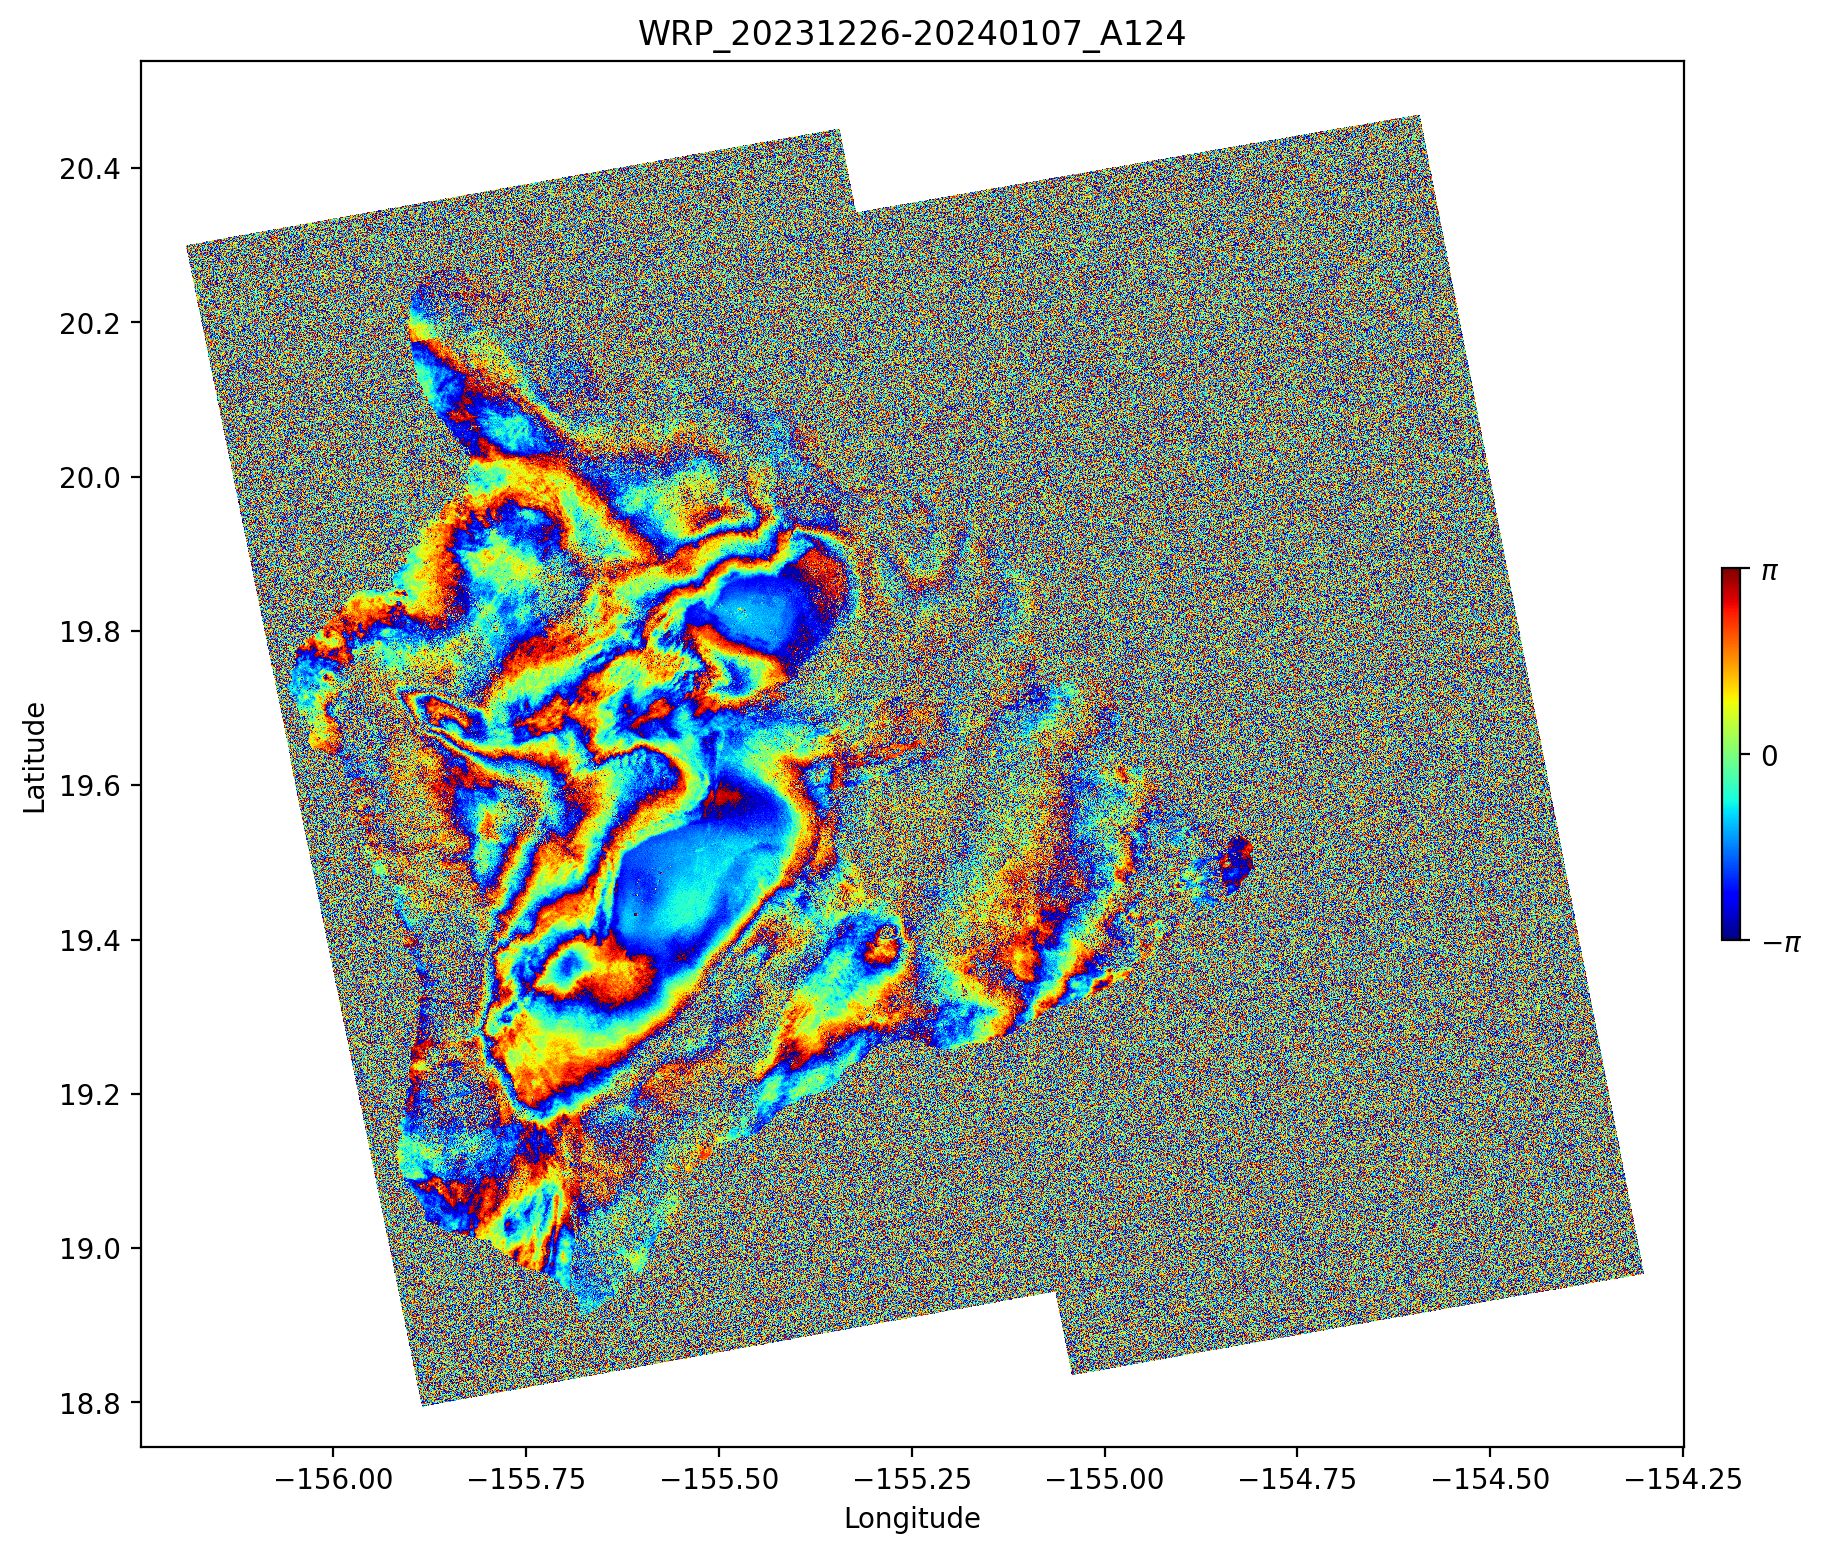

In [20]:
# Define bounding box
bbox = [minlon,maxlon,minlat,maxlat]

# Plot using Matplotlib
fig, ax = plt.subplots(figsize=[12,9])
cax = ax.imshow(merged_ifg, cmap='jet',interpolation='nearest', origin='upper',extent=bbox)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'WRP_{ref}-{sec}_{orbitPass[0]}{pathNumber}',fontsize=12)
cbar = fig.colorbar(cax,orientation='vertical',fraction=0.01,pad=0.02)
cbar.set_ticks([-np.pi, 0., np.pi])
cbar.set_ticklabels([r'$-\pi$', '$0$', r'$\pi$'])
plt.show()

In [21]:
## Set Reference Points
xsize = 0.000277778; ysize = -0.000277778           # Assuming 30-m resolution
refx = 2642; refy = 2700;
reflon = minlon + (refx * xsize)
reflat = maxlat + (refy * ysize)

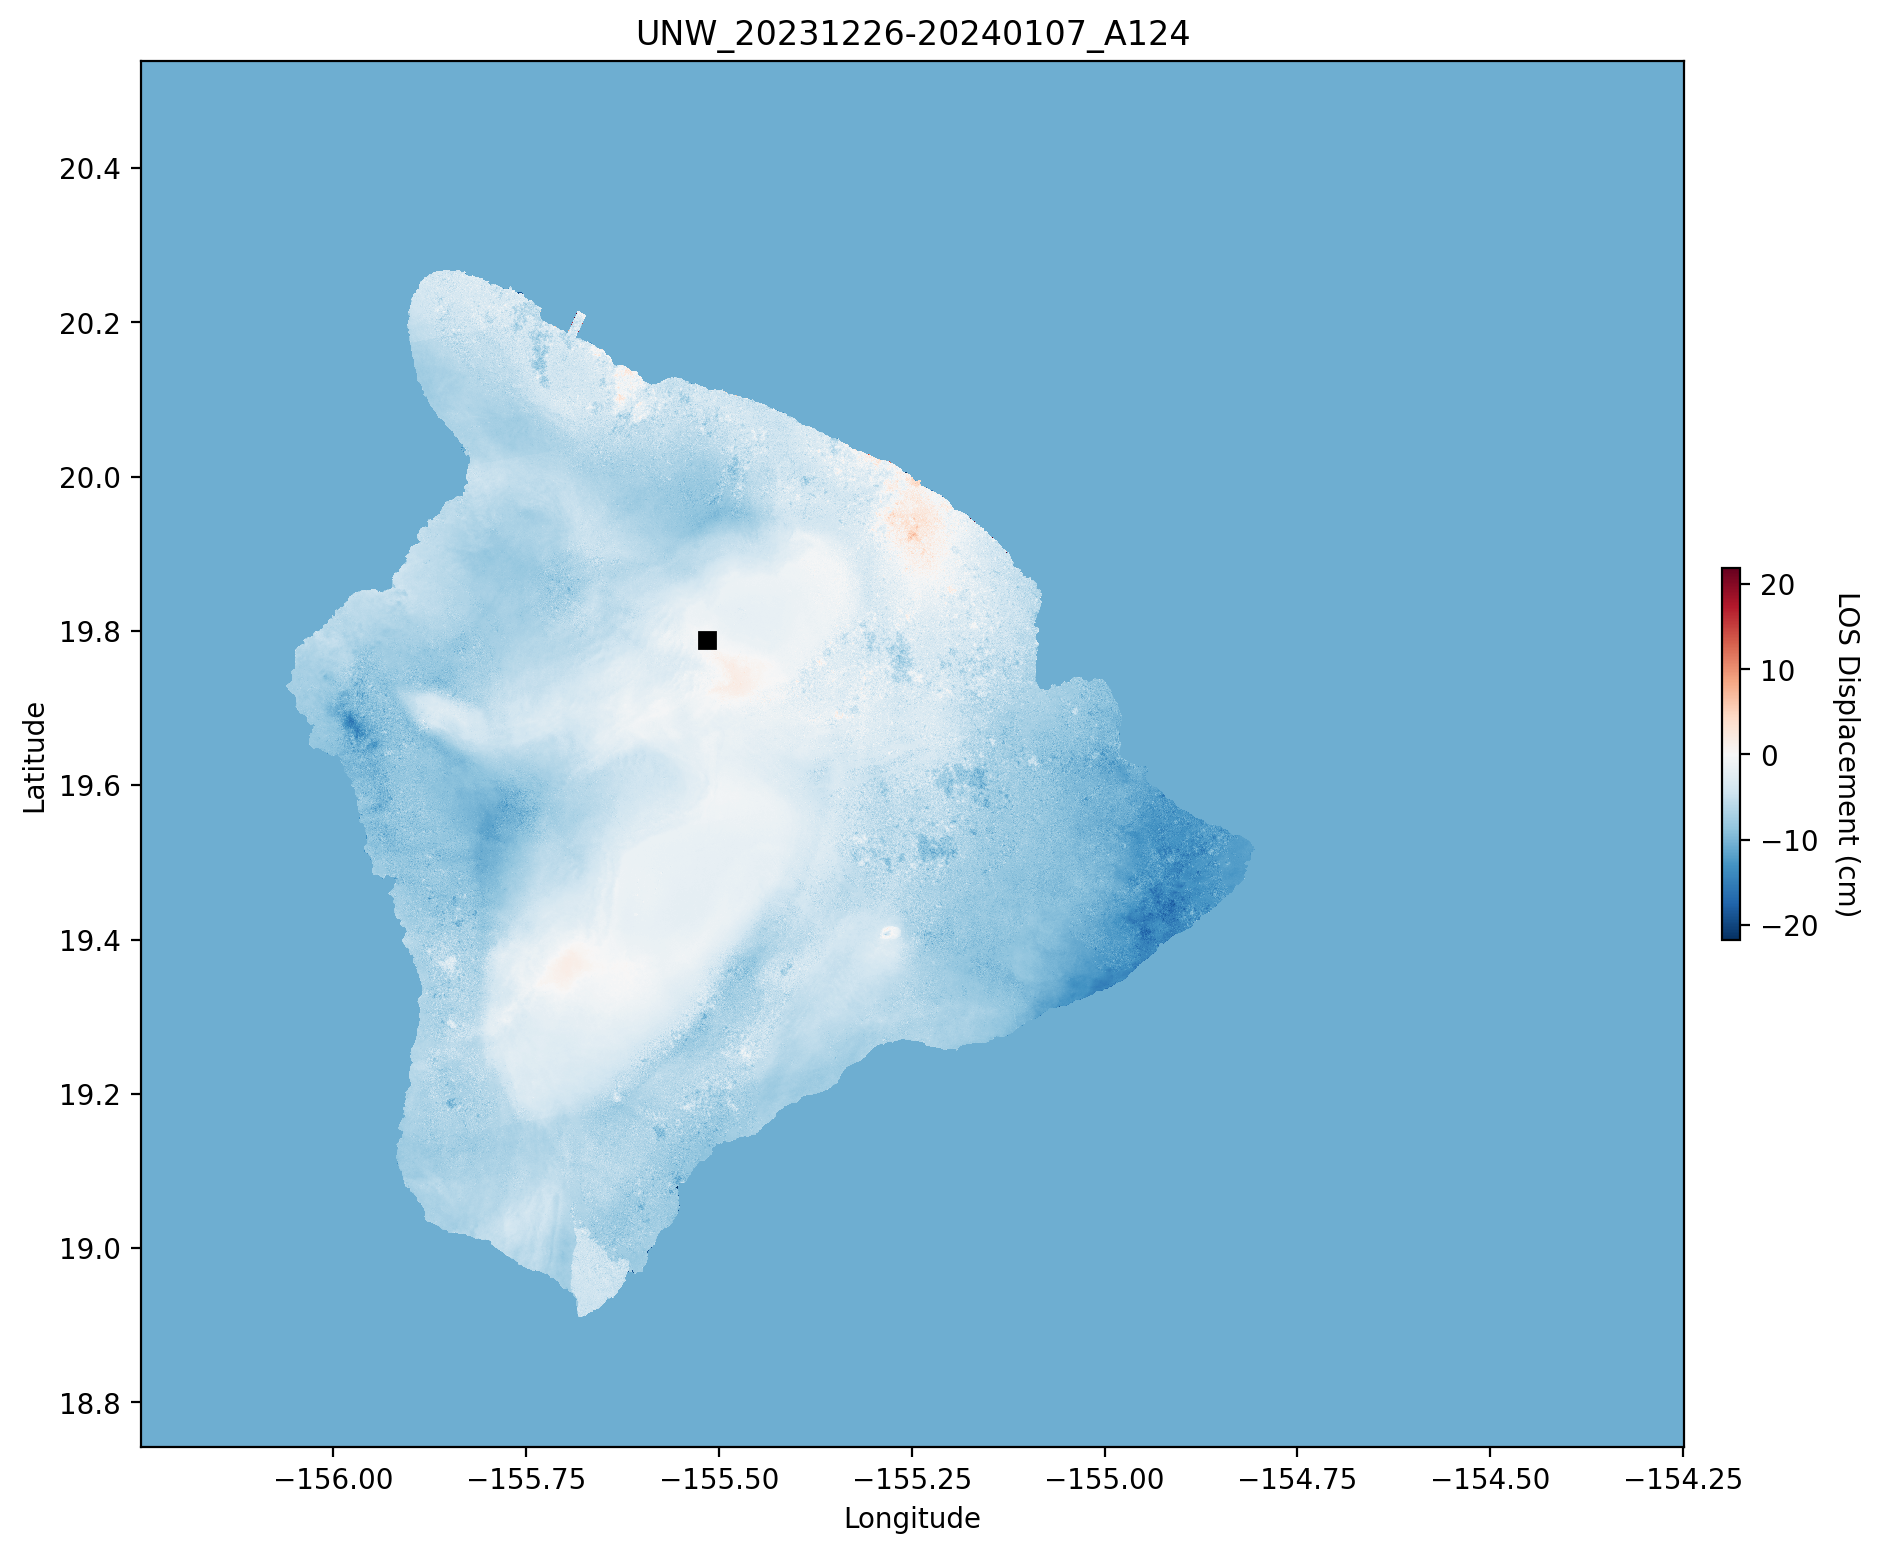

In [22]:
# Read the unwrapped file
src = rioxarray.open_rasterio(f'./unwrapped/{ref}_{sec}.unw.tif')
merged_unw = src.rio.reproject("EPSG:4326")[0] * wavelength / (-4 * np.pi)
src = []

# Plot using Matplotlib
fig, ax = plt.subplots(figsize=[12,9])
merged_unw_cm = merged_unw*100
merged_unw_cm -= merged_unw_cm[refy, refx]              # Reference the data to a point
cax = ax.imshow(merged_unw_cm, cmap='RdBu_r',interpolation='nearest', origin='upper', extent=bbox, vmin=np.min(merged_unw_cm), vmax=-np.min(merged_unw_cm))
ax.plot(reflon, reflat, 'ks')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'UNW_{ref}-{sec}_{orbitPass[0]}{pathNumber}',fontsize=12)
cbar = fig.colorbar(cax,orientation='vertical',fraction=0.01,pad=0.02)
cbar.set_label('LOS Displacement (cm)', rotation=270, labelpad=15)
plt.show()

In [23]:
# Delete temporary "cslc" folder to save storage space
!rm -rvf ./cslc

removed ‘./cslc/OPERA_L2_CSLC-S1_T124-264309-IW2_20240107T043127Z_20240109T035704Z_S1A_VV_v1.0.h5’
removed ‘./cslc/OPERA_L2_CSLC-S1_T124-264309-IW3_20240107T043128Z_20240109T035704Z_S1A_VV_v1.0.h5’
removed ‘./cslc/OPERA_L2_CSLC-S1_T124-264308-IW2_20240107T043124Z_20240109T035714Z_S1A_VV_v1.0.h5’
removed ‘./cslc/OPERA_L2_CSLC-S1_T124-264311-IW2_20240107T043132Z_20240109T035704Z_S1A_VV_v1.0.h5’
removed ‘./cslc/OPERA_L2_CSLC-S1_T124-264308-IW3_20240107T043125Z_20240109T035714Z_S1A_VV_v1.0.h5’
removed ‘./cslc/OPERA_L2_CSLC-S1_T124-264310-IW3_20240107T043131Z_20240109T035704Z_S1A_VV_v1.0.h5’
removed ‘./cslc/OPERA_L2_CSLC-S1_T124-264307-IW3_20240107T043122Z_20240109T035714Z_S1A_VV_v1.0.h5’
removed ‘./cslc/OPERA_L2_CSLC-S1_T124-264307-IW2_20240107T043121Z_20240109T035714Z_S1A_VV_v1.0.h5’
removed ‘./cslc/OPERA_L2_CSLC-S1_T124-264310-IW2_20240107T043130Z_20240109T035704Z_S1A_VV_v1.0.h5’
removed ‘./cslc/OPERA_L2_CSLC-S1_T124-264306-IW3_20240107T043120Z_20240109T035714Z_S1A_VV_v1.0.h5’
removed ‘.